# Setup

In [5]:
import pandas as pd
import numpy as np

from causalAssembly.models_dag import ProductionLineGraph
from causalAssembly.drf_fitting import fit_drf

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG

from castle.algorithms import Notears
from dagma.linear import DagmaLinear
from castle.algorithms import GAE
from castle.algorithms import DirectLiNGAM
from castle.algorithms import PC


import torch
import time
import csv

import networkx as nx
import matplotlib.pyplot as plt

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-28 08:25:19,802 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-06-28 08:25:19,859 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


set up testing collection df

In [17]:
testing_results_columns = ['date', 'dataset', 'subset', 'n', 'method', 'runtime', 'hyperparams',
                                        'fdr', 'tpr', 'fpr', 'shd', 'nnz', 'precision', 'recall', 'F1', 'gscore']

# Check if the file exists
try:
    with open('testing_results.csv', 'r') as csvfile:
        print("File 'testing_results.csv' already exists.")
except FileNotFoundError:
    # Create a new file with the specified columns
    with open('testing_results.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(testing_results_columns)
        print("New file 'testing_results.csv' created with the specified columns.")


File 'testing_results.csv' already exists.


Function to save the date to the testing_results.csv

In [2]:
def add_results(dataset, subset, n, method, runtime, hyperparams, metrics):
    with open('testing_results.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([time.strftime("%Y-%m-%d %H:%M:%S"), 
                        dataset, 
                        subset,
                        n, 
                        method, 
                        runtime, 
                        hyperparams,
                        metrics['fdr'],
                        metrics['tpr'],
                        metrics['fpr'],
                        metrics['shd'],
                        metrics['nnz'],
                        metrics['precision'],
                        metrics['recall'],
                        metrics['F1'],
                        metrics['gscore']]
                        )
        print("Results added to 'testing_results.csv'.")

Function to generate and save a graph plot next to a heatmap

In [79]:
def plot_graph_adjacency_matrix(ground_truth, save_name):

    # create figure
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 8), ncols=2)

    # subplot for graph
    ax1.set_title('Graph', y= 1.05)
    G = nx.from_numpy_matrix(ground_truth, create_using=nx.DiGraph)
    nx.draw(G, ax=ax1, with_labels=True)

    # subplot for heatmap
    ax2.set_title('Adjazenzmatrix Heat Map', y= 1.05)
    map1 = ax2.imshow(ground_truth, cmap='Greys', interpolation='none')
    cbar = fig.colorbar(map1, ax=ax2)
    cbar.ax.set_position([cbar.ax.get_position().x0, ax2.get_position().y0,
                        cbar.ax.get_position().width, ax2.get_position().height])

    # Ensure subplots have same height and position in y direction
    ax1_height = ax2.get_position().height
    ax1.set_position([ax1.get_position().x0, ax2.get_position().y0,
                    ax1.get_position().width, ax1_height])
    ax2.set_position([ax2.get_position().x0, ax2.get_position().y0,
                    ax2.get_position().width, ax1_height])

    # save
    plt.savefig(save_name)
    plt.show()

function to only save a heat map

In [219]:
def plot_heatmap(ground_truth, method, save_name):
    
    # create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # subplot for heatmap
    ax.set_title(method, y= 1.05)
    map1 = ax.imshow(ground_truth, cmap='Greys', interpolation='none')
    cbar = fig.colorbar(map1, ax=ax)
    cbar.ax.set_position([cbar.ax.get_position().x0, ax.get_position().y0,
                        cbar.ax.get_position().width, ax.get_position().height])

    # save
    plt.savefig(save_name)
    plt.show()

test set up

In [260]:
def run_tests(dataset, subset, algorithms, sample_sizes):
    
    ground_truth = pd.read_csv(f'data/{dataset}/{subset}/{subset}_ground_truth.csv').to_numpy()
    
    for sample_size in sample_sizes:

        data = pd.read_csv(f'data/{dataset}/{subset}/{subset}_data_{sample_size}.csv').to_numpy()

        # go over all algorithms
        for algorithm in algorithms:

            # set different params for the different models
            match algorithm:

                case 'NotearsLinear':
                    model = Notears()
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()             

                case 'DagmaLinear':
                    model = DagmaLinear(loss_type='logistic')
                    start_time = time.time()
                    W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
                    end_time = time.time()

                case 'GAE':
                    model = GAE(epochs=3)
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()

                case 'DirectLiNGAM':
                    model = DirectLiNGAM()
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()

                case 'PC':
                    model = PC(variant = 'stable')
                    start_time = time.time()
                    model.learn(data)
                    end_time = time.time()


            # calculate runtime
            runtime = end_time - start_time

            # plot comparison graph
            name = f'{algorithm}_{sample_size}'
            print(name)
            save_name1 = f'plots/adj_matrix_comparison/{dataset}/{subset}/{name}.png'

            # plot only heatmap for later comparison
            save_name2 = f'plots/adj_matrix/{dataset}/{subset}/{name}.png'

            # save adj_matrix as csv
            save_name3 = f'plots/adj_matrix_csv/{dataset}/{subset}/{name}.csv'

            match algorithm:
                case 'NotearsLinear':
                    met = MetricsDAG(model.causal_matrix, ground_truth)
                    GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                    plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                    df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))
                case 'DagmaLinear':
                    met = MetricsDAG(W_est, ground_truth)
                    GraphDAG(W_est, ground_truth, save_name = save_name1)
                    plot_heatmap(W_est, method = algorithm, save_name = save_name2)
                    df = pd.DataFrame(np.array(W_est.tolist()).reshape(W_est.shape))
                case 'GAE':
                    met = MetricsDAG(model.causal_matrix, ground_truth)
                    GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                    plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                    df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))
                case 'DirectLiNGAM':
                    met = MetricsDAG(model.causal_matrix, ground_truth)
                    GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                    plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                    df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))
                case 'PC':
                    met = MetricsDAG(model.causal_matrix, ground_truth)
                    GraphDAG(model.causal_matrix, ground_truth, save_name = save_name1)
                    plot_heatmap(model.causal_matrix, method = algorithm, save_name = save_name2)
                    df = pd.DataFrame(np.array(model.causal_matrix.tolist()).reshape(model.causal_matrix.shape))

            # save adj matrix to csv
            df.to_csv(save_name3, index=False)

            # save metrics to csv
            add_results(dataset, subset, sample_size, algorithm, runtime, None, met.metrics) 

# causalAssembly

## demo setup

with alternating sample sizes

In [26]:
seed = 2023
n_select = 2000

assembly_line_data = ProductionLineGraph.get_data()

# take subsample for demonstration purposes
assembly_line_data = assembly_line_data.sample(
    n_select, random_state=seed, replace=False
)

# load in ground truth
assembly_line = ProductionLineGraph.get_ground_truth()

# fit drf and sample for entire line
assembly_line.drf = fit_drf(assembly_line, data=assembly_line_data)
assembly_line_sample = assembly_line.sample_from_drf(size=n_select)

# fit drf and sample for station3
assembly_line.Station3.drf = fit_drf(assembly_line.Station3, data=assembly_line_data)
station3_sample = assembly_line.Station3.sample_from_drf(size=n_select)

In [35]:
# save data to csv
assembly_line_sample.to_csv(f'data/causalAssembly/assembly_line_data_{assembly_line_sample.shape[0]}.csv', index=False)
station3_sample.to_csv(f'data/causalAssembly/station3_data_{station3_sample.shape[0]}.csv', index=False)

# save ground truth to csv
assembly_line.ground_truth.to_csv('data/causalAssembly/assembly_line_ground_truth.csv', index=False)
assembly_line.Station3.ground_truth.to_csv('data/causalAssembly/station3_ground_truth.csv', index=False)

get and save data for Station2

In [54]:
n_select = 2000

# fit drf and sample for station3
assembly_line.Station2.drf = fit_drf(assembly_line.Station2, data=assembly_line_data)
station2_sample = assembly_line.Station2.sample_from_drf(size=n_select)

# save data to csv
station2_sample.to_csv(f'data/causalAssembly/station2_data_{station2_sample.shape[0]}.csv', index=False)
assembly_line.Station2.ground_truth.to_csv('data/causalAssembly/station2_ground_truth.csv', index=False)

investigate ground truths

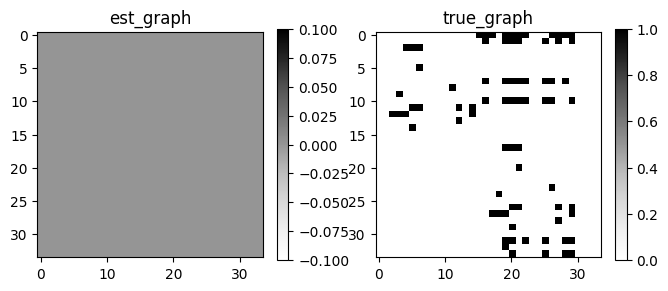

In [53]:
GraphDAG(
    np.zeros(assembly_line.Station2.ground_truth.to_numpy().shape), 
    assembly_line.Station2.ground_truth.to_numpy()
    )

### DAG-MA linear

In [57]:
from dagma import utils
from dagma.linear import DagmaLinear

learn model

In [5]:
model = DagmaLinear(loss_type='logistic')
W_est = (model.fit(data.X, max_iter=1e6) > 0.5).astype("int32")
GraphDAG(W_est, data.B)
metrics = MetricsDAG(W_est, data.B)
print(metrics.metrics)

  1%|          | 6040/1120000.0 [01:47<5:30:27, 56.18it/s]


KeyboardInterrupt: 

#### assembly data

In [60]:
data = pd.read_csv('data/causalAssembly/demo_data/assembly_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/assembly_line_ground_truth.csv').to_numpy()

model = DagmaLinear(loss_type='logistic')
start_time = time.time()
causal_matrix = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
end_time = time.time()
runtime = end_time - start_time

GraphDAG(causal_matrix, ground_truth)
met = MetricsDAG(causal_matrix, ground_truth)
add_results('causalAssembly', 'assembly_line', data.shape[0] , 'DagmaLinear', runtime, None, met.metrics)
print(met.metrics)

  0%|          | 0/1120000.0 [00:00<?, ?it/s]

  0%|          | 825/1120000.0 [02:04<46:44:49,  6.65it/s]


KeyboardInterrupt: 

#### Station 3

##### sample size 500

In [10]:
data = pd.read_csv('data/causalAssembly/demo_data/station3_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/station3_ground_truth.csv').to_numpy()

100%|██████████| 1120000/1120000.0 [05:18<00:00, 3516.20it/s]


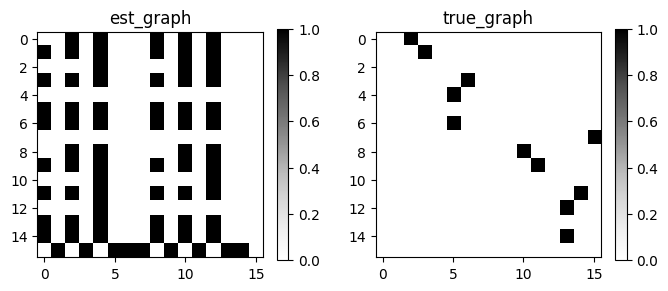

{'fdr': 0.9722, 'tpr': 0.1818, 'fpr': 0.6422, 'shd': 76, 'nnz': 72, 'precision': 0.0278, 'recall': 0.1818, 'F1': 0.0482, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [11]:
model = DagmaLinear(loss_type='logistic')

start_time = time.time()
W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
end_time = time.time()
runtime = end_time - start_time

# plot prediction vs orginal
GraphDAG(W_est, ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, ground_truth)
add_results('causalAssembly', 'demo_station3', 500, 'DagmaLinear', runtime, 'max_iter=1e6', metrics.metrics)
print(metrics.metrics)

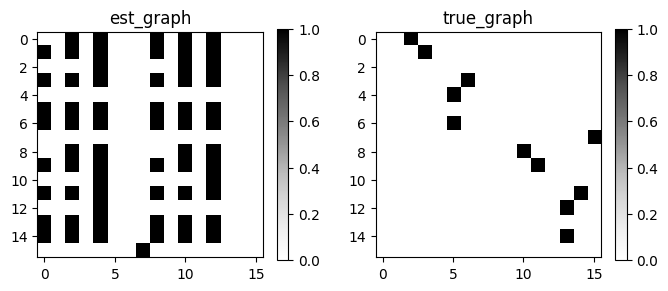

{'fdr': 0.9688, 'tpr': 0.1818, 'fpr': 0.5688, 'shd': 68, 'nnz': 64, 'precision': 0.0312, 'recall': 0.1818, 'F1': 0.0533, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


##### sample size 2000

In [36]:
data = pd.read_csv('data/causalAssembly/station3_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station3_ground_truth.csv').to_numpy()

In [29]:
model = DagmaLinear(loss_type='logistic')
W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")

# plot prediction vs orginal
GraphDAG(W_est, ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, ground_truth)
print(metrics.metrics)

100%|██████████| 1120000/1120000.0 [26:33<00:00, 702.85it/s]


IndexError: index 16 is out of bounds for axis 0 with size 16

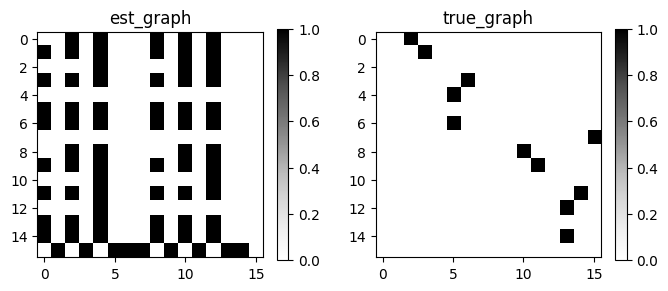

{'fdr': 0.9722, 'tpr': 0.1818, 'fpr': 0.6422, 'shd': 76, 'nnz': 72, 'precision': 0.0278, 'recall': 0.1818, 'F1': 0.0482, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [37]:
# plot prediction vs orginal
GraphDAG(W_est, ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, ground_truth)
print(metrics.metrics)

#### Station 2

In [55]:
data = pd.read_csv('data/causalAssembly/station2_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station2_ground_truth.csv').to_numpy()

In [56]:
model = DagmaLinear(loss_type='logistic')
W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")

# plot prediction vs orginal
GraphDAG(W_est, ground_truth)

#calculate metrics
metrics = MetricsDAG(W_est, ground_truth)
print(metrics.metrics)

 25%|██▍       | 276058/1120000.0 [09:30<29:02, 484.29it/s]  


KeyboardInterrupt: 

### DAG-MA NonLinear

In [64]:
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

#### assembly data

In [69]:
from timeit import default_timer as timer
import utils

utils.set_random_seed(1)
torch.manual_seed(1)

n, d, s0, graph_type, sem_type = 1000, 20, 20, 'ER', 'mlp'
B_true = utils.simulate_dag(d, s0, graph_type)
X = utils.simulate_nonlinear_sem(B_true, n, sem_type)

ModuleNotFoundError: No module named 'utils'

In [66]:
data = pd.read_csv('data/causalAssembly/demo_data/assembly_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/assembly_line_ground_truth.csv').to_numpy()

eq_model = DagmaMLP(dims=[20, 10, 1], bias=True)
model = DagmaNonlinear(eq_model)
start_time = time.time()
causal_matrix = (model.fit(data, lambda1=0.02, lambda2=0.005)).astype("int32")
end_time = time.time()
runtime = end_time - start_time

GraphDAG(causal_matrix, ground_truth)
met = MetricsDAG(causal_matrix, ground_truth)
add_results('causalAssembly', 'assembly_line', data.shape[0] , 'DagmaLinear', runtime, None, met.metrics)
print(met.metrics)

  0%|          | 0/230000.0 [00:00<?, ?it/s]

  0%|          | 0/230000.0 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x98 and 20x200)

### DAG-MA MLP

In [ ]:
from dagma.nonlinear import DagmaMLP

#### assembly data

### NOTEARS LINEAR

In [15]:
from castle.algorithms import Notears
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

2024-06-24 10:37:08,474 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-06-24 10:37:08,660 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


#### IID_Test data

2024-06-24 10:40:14,254 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-24 10:40:14,257 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16
2024-06-24 10:40:14,667 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=6.738e-01, loss=171.797, rho=1.0e+00
2024-06-24 10:40:14,913 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=4.604e-01, loss=4.593, rho=1.0e+00
2024-06-24 10:40:15,269 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=2.170e-01, loss=6.636, rho=1.0e+01
2024

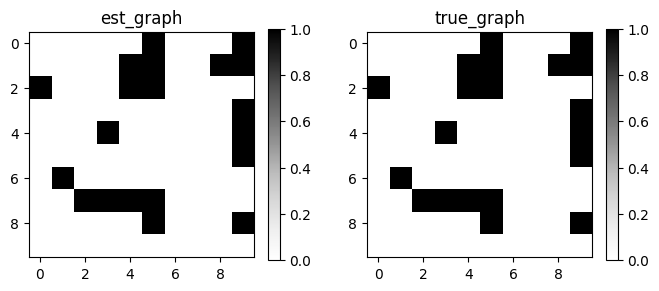

Results added to 'testing_results.csv'.
{'fdr': 0.0, 'tpr': 1.0, 'fpr': 0.0, 'shd': 0, 'nnz': 20, 'precision': 1.0, 'recall': 1.0, 'F1': 1.0, 'gscore': 1.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [18]:
X, true_dag, _ = load_dataset('IID_Test')

n = Notears()
start_time = time.time()
n.learn(X)
end_time = time.time()
runtime = end_time - start_time


GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
# add the resulsts to the testing_results df
add_results('IID_Test', 'all', X.shape[0], 'NotearsLinear', runtime, None, met.metrics)
print(met.metrics)

#### assembly line

2024-06-24 13:32:42,749 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=500, d=98, iter_=100, h_=1e-08, rho_=1e+16


2024-06-24 13:48:50,922 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=2.320e+00, loss=6881928461950.820, rho=1.0e+00
2024-06-24 13:53:51,354 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=3.208e+00, loss=4705454388561.074, rho=1.0e+00
2024-06-24 14:02:13,903 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=3.097e+00, loss=4705454388585.304, rho=1.0e+01
2024-06-24 14:09:51,450 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=3.654e+00, loss=4705454388827.597, rho=1.0e+02
2024-06-24 14:17:16,265 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear

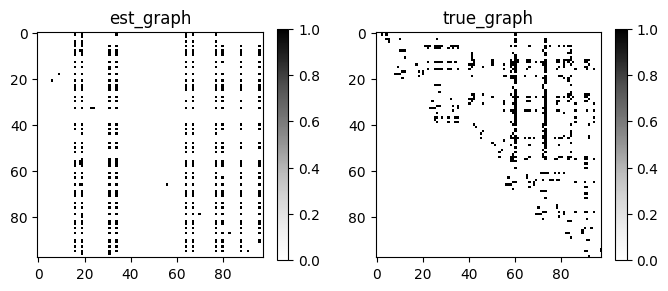

Results added to 'testing_results.csv'.
{'fdr': 0.9714, 'tpr': 0.0247, 'fpr': 0.0954, 'shd': 851, 'nnz': 419, 'precision': 0.0286, 'recall': 0.0247, 'F1': 0.0265, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [117]:
data = pd.read_csv('data/causalAssembly/demo_data/assembly_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/assembly_line_ground_truth.csv').to_numpy()

n = Notears()
start_time = time.time()
n.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
add_results('causalAssembly', 'assembly_line', 500, 'NotearsLinear', runtime, None, met.metrics)
print(met.metrics)

#### station 3

##### sample size 2000

2024-06-19 12:19:50,308 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=16, iter_=100, h_=1e-08, rho_=1e+16


2024-06-19 12:19:50,613 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=1.273e+00, loss=475.790, rho=1.0e+00
2024-06-19 12:19:50,681 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=1.230e+00, loss=89.663, rho=1.0e+00
2024-06-19 12:19:50,856 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=9.994e-01, loss=96.957, rho=1.0e+01
2024-06-19 12:19:50,948 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=5.373e-01, loss=169.897, rho=1.0e+02
2024-06-19 12:19:51,113 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=2.064e-01

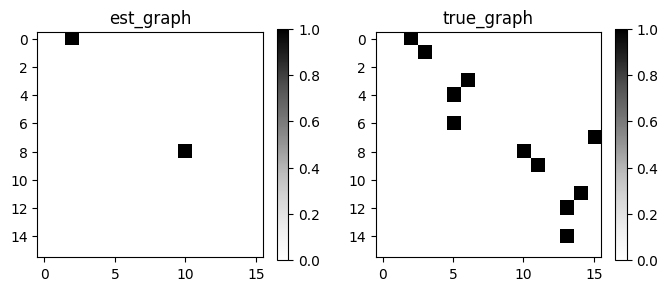

{'fdr': 0.0, 'tpr': 0.1818, 'fpr': 0.0, 'shd': 9, 'nnz': 2, 'precision': 1.0, 'recall': 0.1818, 'F1': 0.3077, 'gscore': 0.1818}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [11]:
data = pd.read_csv('data/causalAssembly/station3_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station3_ground_truth.csv').to_numpy()

n = Notears()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
print(met.metrics)

#### station2

##### sample size 2000

2024-06-19 12:21:18,818 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=34, iter_=100, h_=1e-08, rho_=1e+16
2024-06-19 12:21:29,188 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=8.112e+00, loss=4690538063731.319, rho=1.0e+00
2024-06-19 12:21:29,236 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=8.107e+00, loss=2512283877873.856, rho=1.0e+00
2024-06-19 12:21:29,283 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=8.106e+00, loss=2512283878169.973, rho=1.0e+01
2024-06-19 12:21:29,331 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py

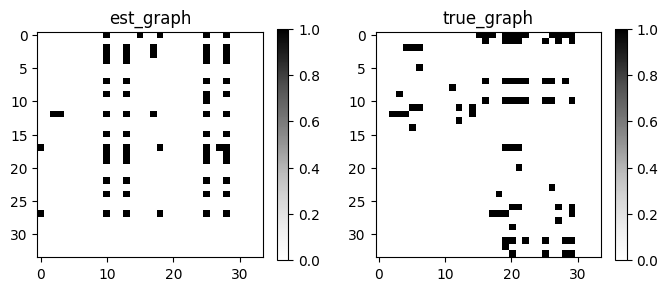

{'fdr': 0.8824, 'tpr': 0.1039, 'fpr': 0.124, 'shd': 122, 'nnz': 68, 'precision': 0.1176, 'recall': 0.1039, 'F1': 0.1103, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [12]:
data = pd.read_csv('data/causalAssembly/station2_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station2_ground_truth.csv').to_numpy()

n = Notears()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
print(met.metrics)

### NOTEARS NON-LINEAR

In [13]:
from castle.algorithms import NotearsNonlinear

#### IID_test data

In [15]:
X, true_dag, _ = load_dataset('IID_Test')
n = NotearsNonlinear()
n.learn(X)
GraphDAG(n.causal_matrix, true_dag)
met = MetricsDAG(n.causal_matrix, true_dag)
print(met.metrics)

2024-06-19 12:24:25,768 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-19 12:24:25,830 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2024-06-19 12:24:25,877 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=2000, d=10, iter_=100, h_=1e-08, rho_=1e+16


KeyboardInterrupt: 

#### station3

##### sample size 500

In [18]:
data = pd.read_csv('data/causalAssembly/station3_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station2_ground_truth.csv').to_numpy()

n = NotearsNonlinear()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
print(met.metrics)

2024-06-19 12:27:36,298 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2024-06-19 12:27:36,301 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=500, d=16, iter_=100, h_=1e-08, rho_=1e+16


KeyboardInterrupt: 

### GAE

In [43]:
from castle.algorithms import GAE

#### IID Simulated data

2024-06-25 11:52:17,712 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-25 11:52:17,714 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-25 11:52:17,718 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-25 11:52:17,830 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 28.167504961707653
2024-06-25 11:52:18,920 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 3.8645167235868367
2024-06-25 11:5

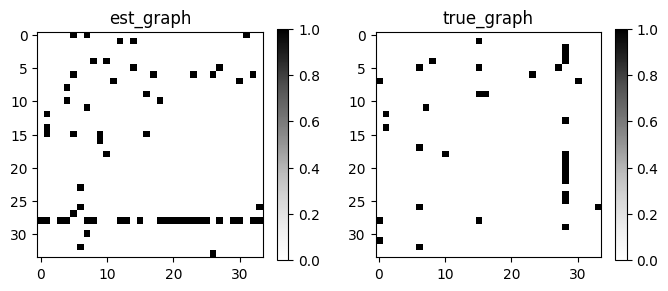

Results added to 'testing_results.csv'.
{'fdr': 0.6889, 'tpr': 0.4242, 'fpr': 0.0587, 'shd': 32, 'nnz': 45, 'precision': 0.2414, 'recall': 0.4242, 'F1': 0.3077, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [45]:
dag = DAG.scale_free(n_nodes=34, n_edges=40)
IIDSimulation_data = IIDSimulation(W=dag, n=1000, method='linear', sem_type='logistic')
data = IIDSimulation_data.X
ground_truth = IIDSimulation_data.B

model = GAE(epochs=3)
start_time = time.time()
model.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(model.causal_matrix, ground_truth)
met = MetricsDAG(model.causal_matrix, ground_truth)
add_results('IID_test', 'all', data.shape[0] , 'GAE', runtime, None, met.metrics)
print(met.metrics)

#### assembly data

2024-06-25 11:58:37,321 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-25 11:58:37,324 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-25 11:58:37,333 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 1621507325430467.8
2024-06-25 11:58:38,830 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 471605621835129.56
2024-06-25 11:58:40,383 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current los

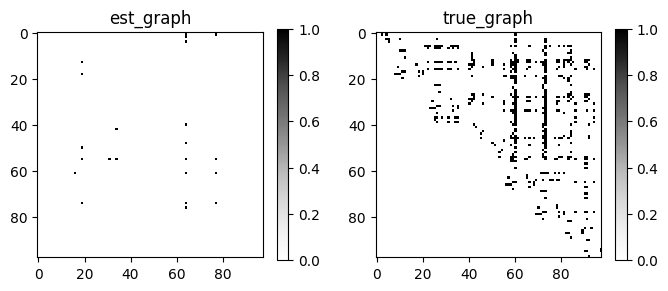

Results added to 'testing_results.csv'.
{'fdr': 0.8636, 'tpr': 0.0062, 'fpr': 0.0045, 'shd': 496, 'nnz': 22, 'precision': 0.1364, 'recall': 0.0062, 'F1': 0.0118, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [50]:
data = pd.read_csv('data/causalAssembly/demo_data/assembly_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/assembly_line_ground_truth.csv').to_numpy()

model = GAE(epochs=3)
start_time = time.time()
model.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(model.causal_matrix, ground_truth)
met = MetricsDAG(model.causal_matrix, ground_truth)
add_results('causalAssembly', 'assembly_line', data.shape[0] , 'GAE', runtime, None, met.metrics)
print(met.metrics)

#### station 3

##### sample size 500

2024-06-25 11:55:14,557 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-25 11:55:14,559 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-25 11:55:14,566 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 626358.8149819861
2024-06-25 11:55:15,363 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 610395.3493146903
2024-06-25 11:55:16,188 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss 

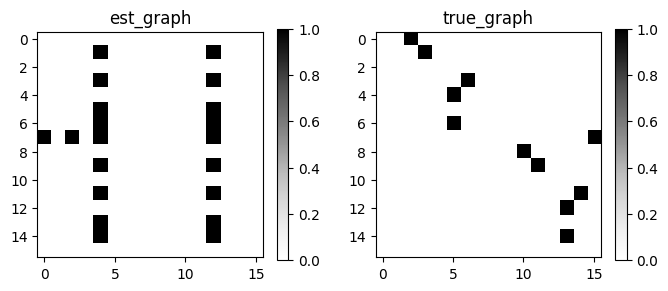

Results added to 'testing_results.csv'.
{'fdr': 1.0, 'tpr': 0.0, 'fpr': 0.1835, 'shd': 29, 'nnz': 20, 'precision': 0.0, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

In [49]:
data = pd.read_csv('data/causalAssembly/demo_data/station3_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/station3_ground_truth.csv').to_numpy()

model = GAE(epochs=3)
start_time = time.time()
model.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(model.causal_matrix, ground_truth)
met = MetricsDAG(model.causal_matrix, ground_truth)
add_results('causalAssembly', 'demo_station3', data.shape[0] , 'GAE', runtime, None, met.metrics)
print(met.metrics)

##### sample size 2000

In [4]:
data = pd.read_csv('data/causalAssembly/station3_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/station3_ground_truth.csv').to_numpy()

In [7]:
n = GAE()
n.learn(data)
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)

2024-06-20 07:50:40,380 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-20 07:50:40,385 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-20 07:50:40,396 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 626358.8149819861
2024-06-20 07:50:41,151 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 610395.3493146903
2024-06-20 07:50:41,889 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss 

NameError: name 'GraphDAG' is not defined

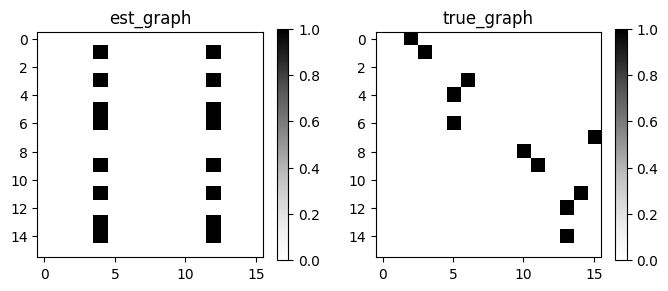

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

In [10]:
GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)

### PC

In [6]:
from castle.algorithms import PC

#### assembly line

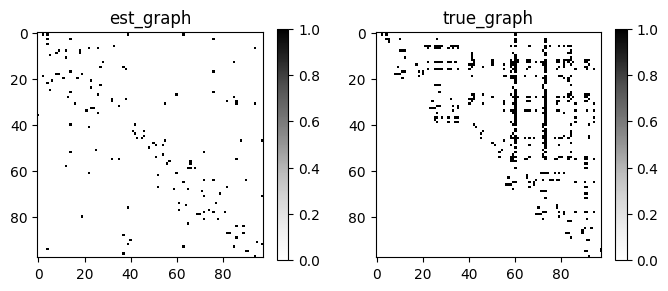

Results added to 'testing_results.csv'.
{'fdr': 0.6434, 'tpr': 0.0948, 'fpr': 0.0194, 'shd': 495, 'nnz': 129, 'precision': 0.3239, 'recall': 0.0948, 'F1': 0.1467, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [20]:
data = pd.read_csv('data/causalAssembly/demo_data/assembly_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/assembly_line_ground_truth.csv').to_numpy()

pc = PC(variant = 'stable')
start_time = time.time()
pc.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(pc.causal_matrix, ground_truth)
met = MetricsDAG(pc.causal_matrix, ground_truth)
add_results('causalAssembly', 'assembly_line', 500, 'PC', runtime, None, met.metrics)
print(met.metrics)

##### 100 runs

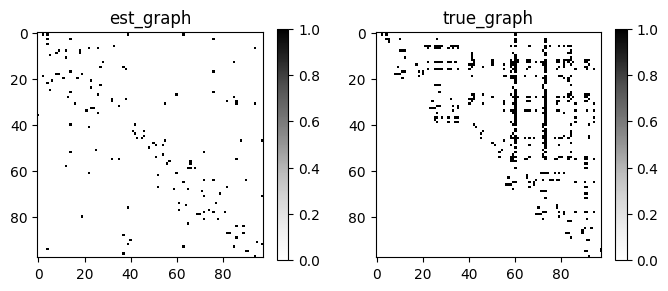

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


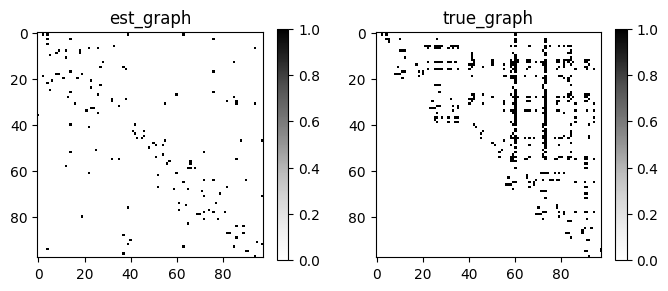

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


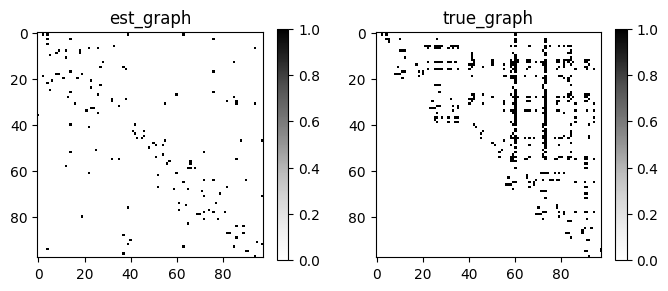

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


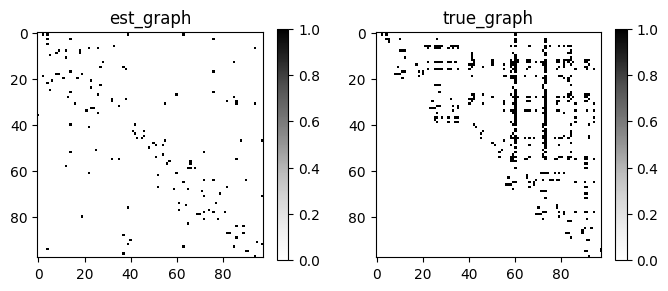

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


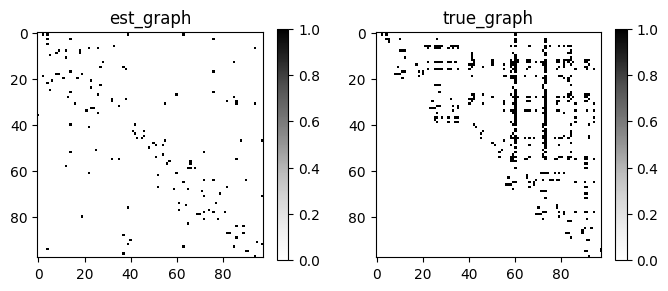

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


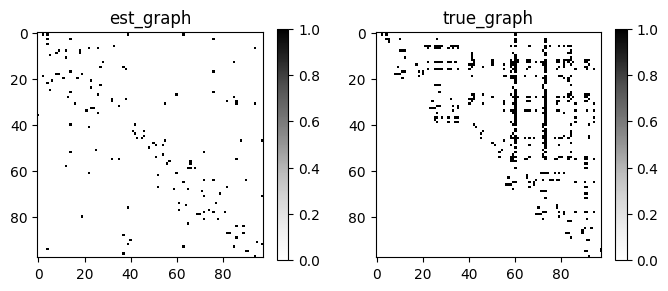

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


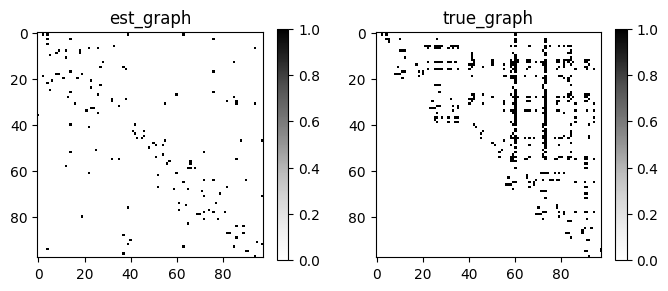

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


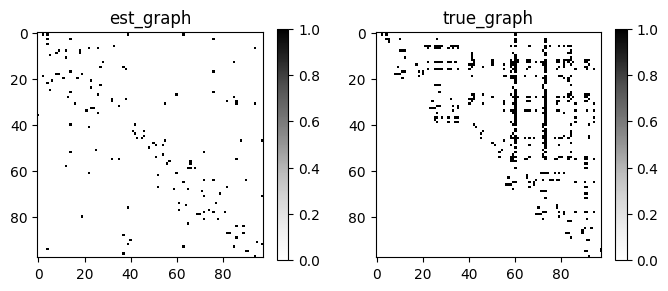

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


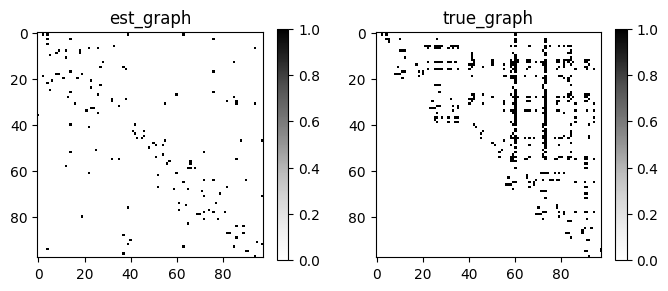

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


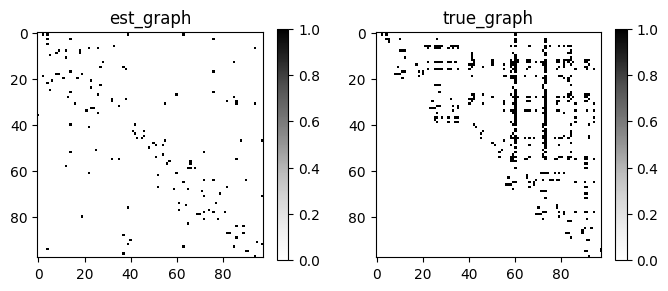

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


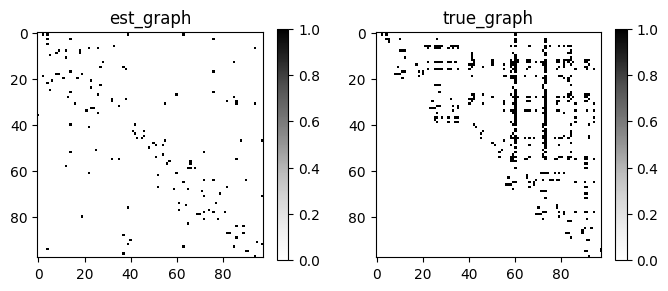

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


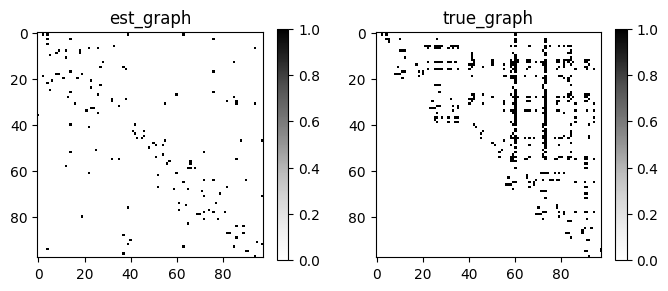

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


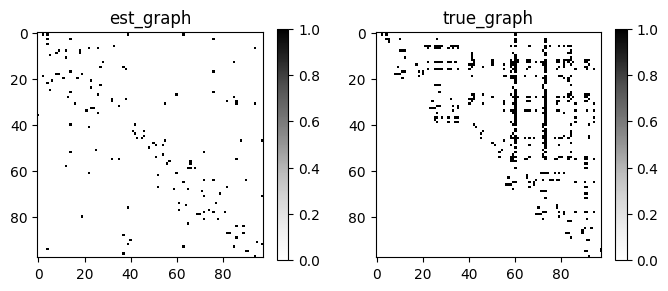

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


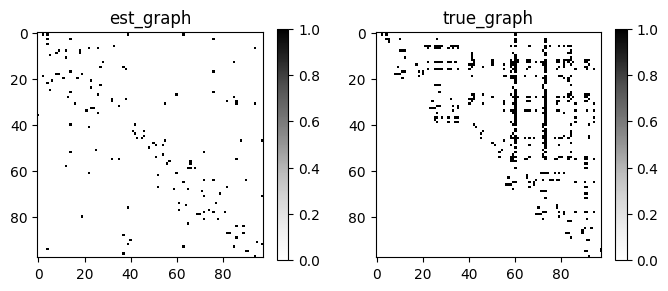

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


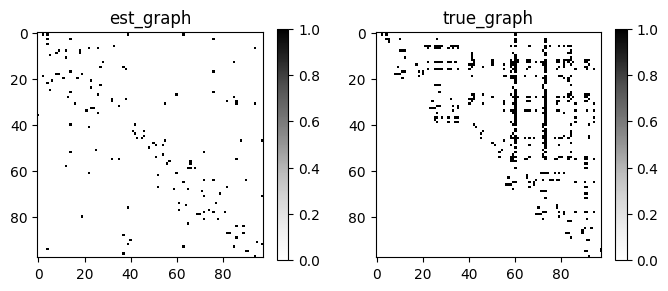

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


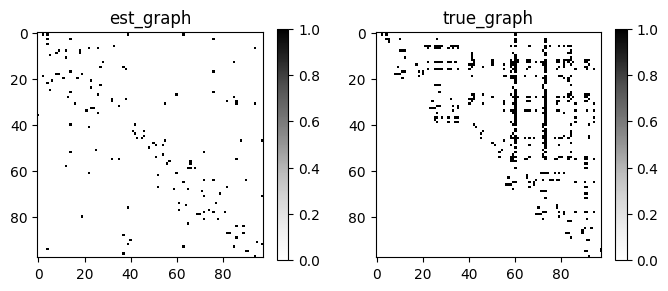

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


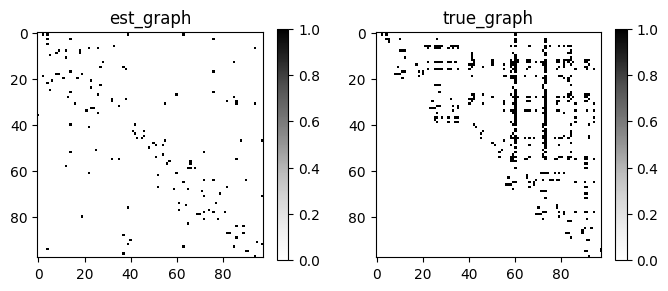

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


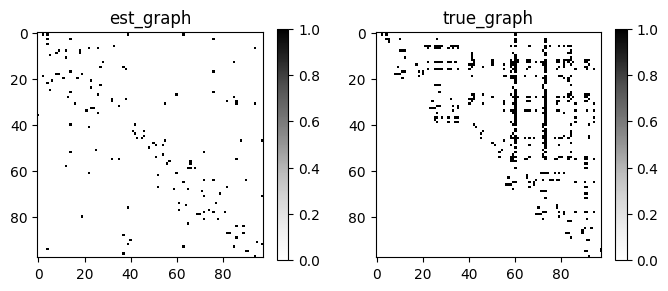

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


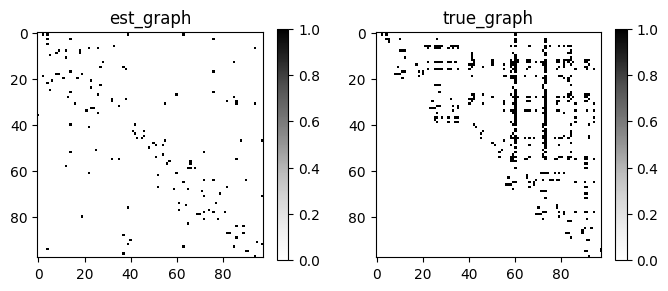

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


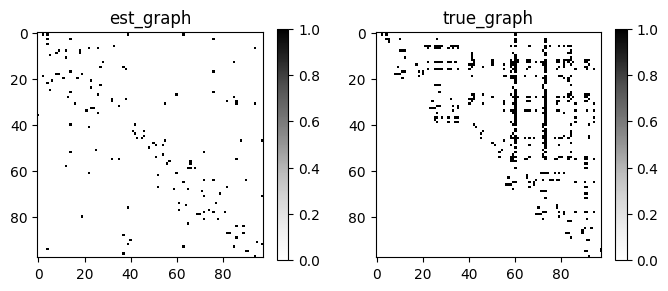

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


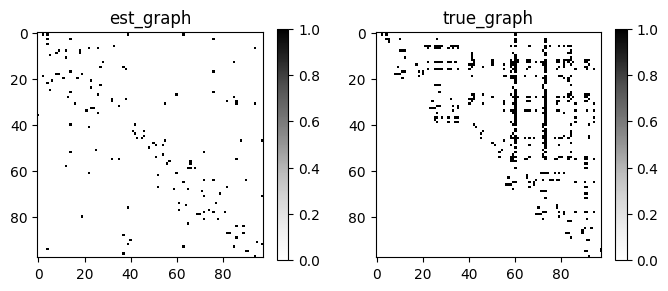

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


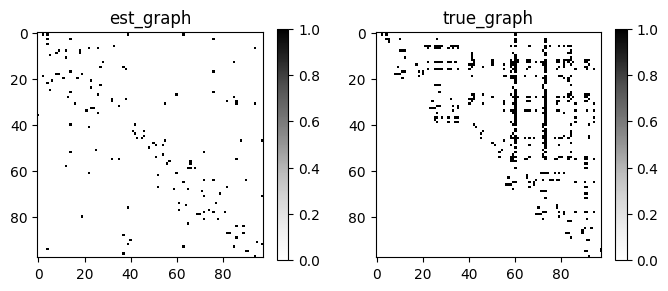

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


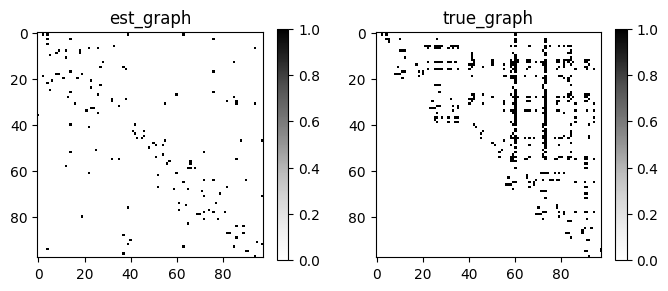

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


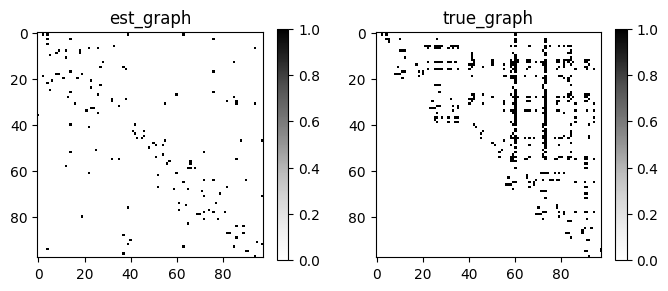

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


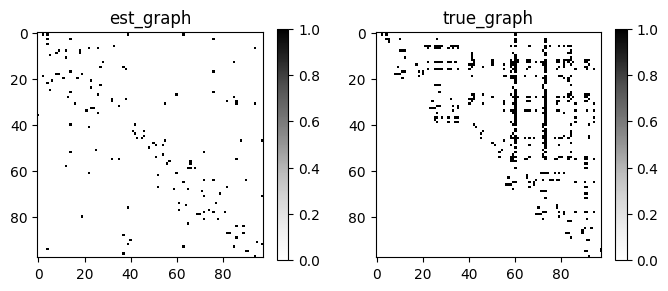

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


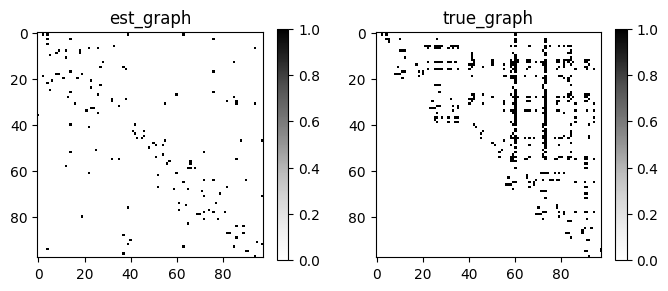

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


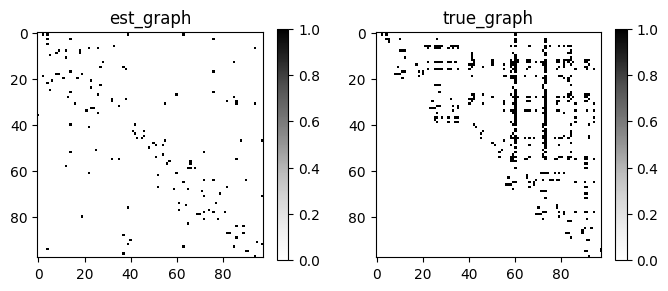

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


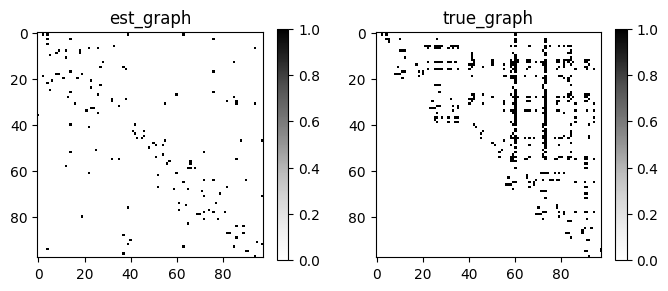

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


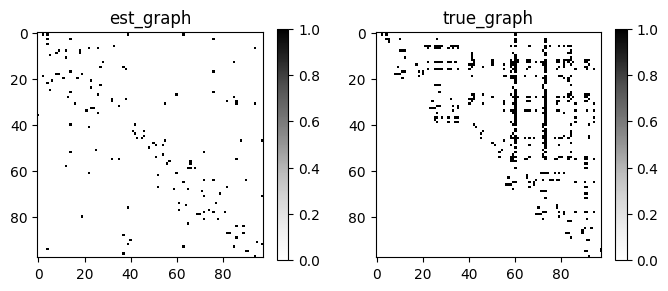

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


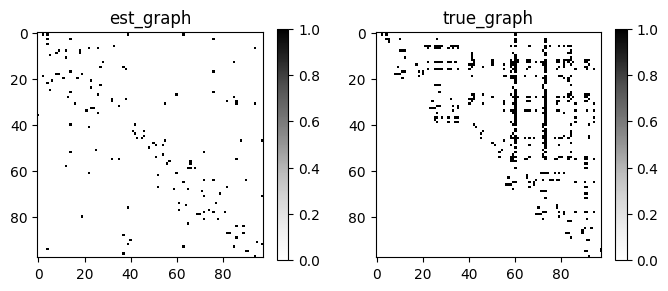

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


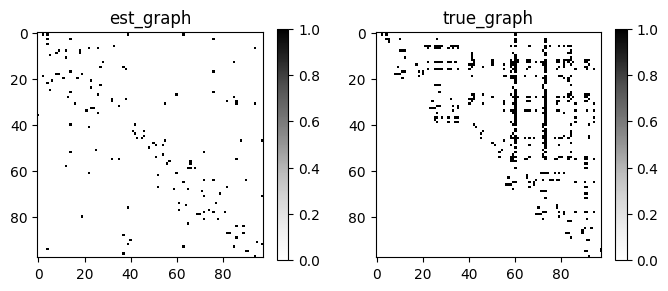

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


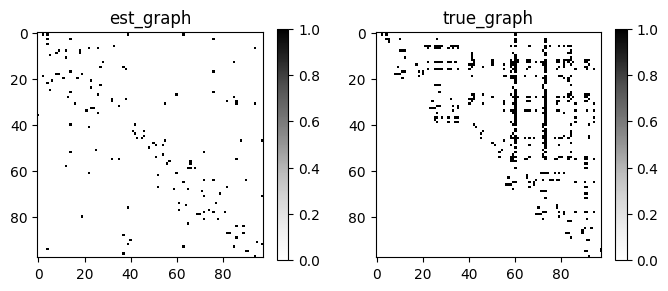

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


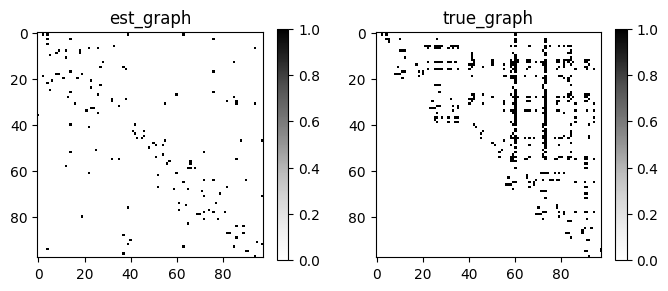

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


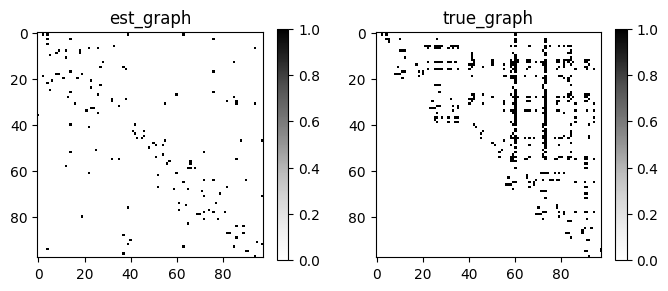

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


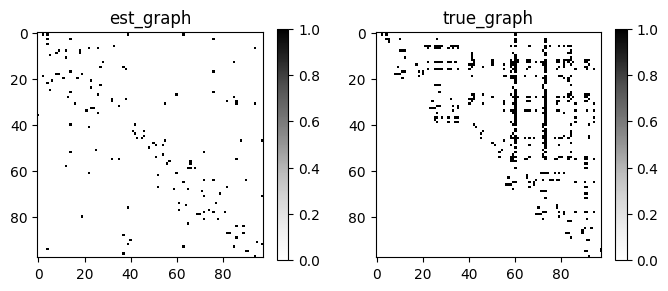

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


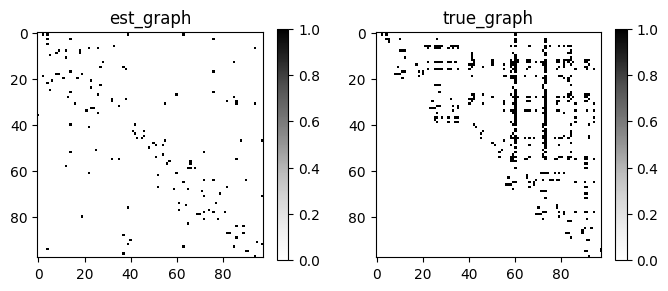

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


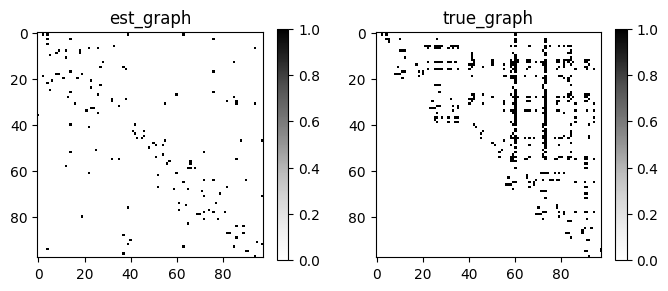

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


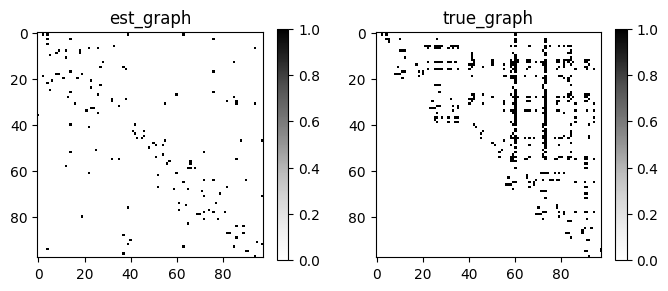

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


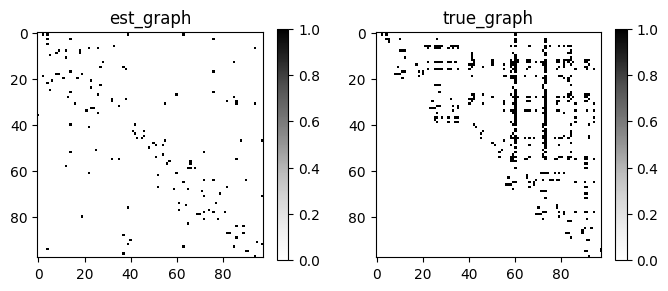

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


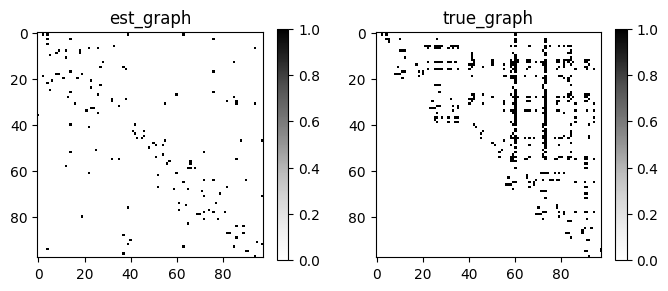

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


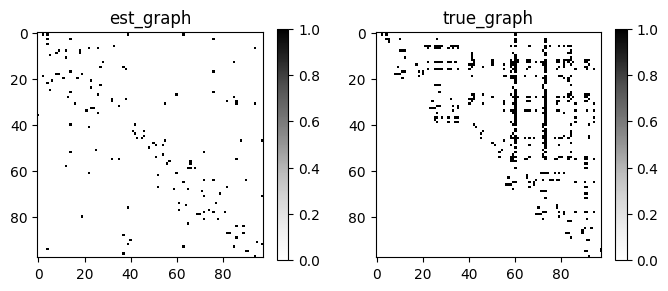

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


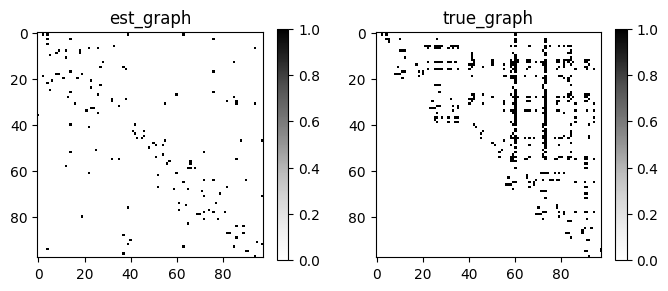

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


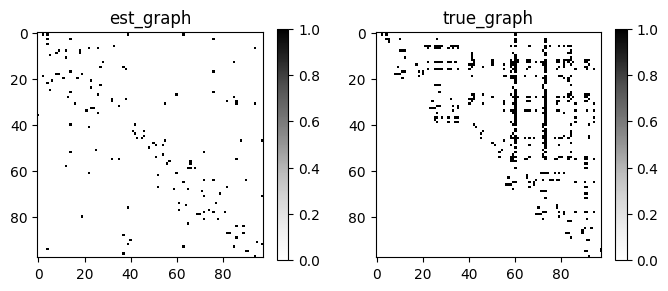

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


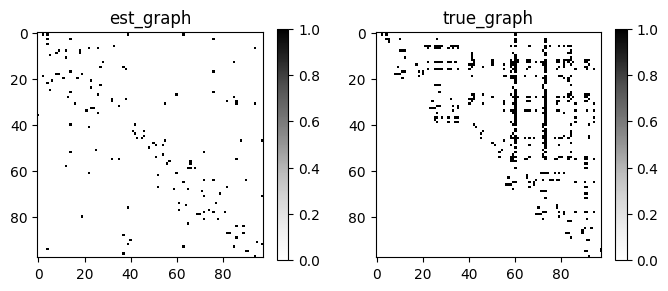

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


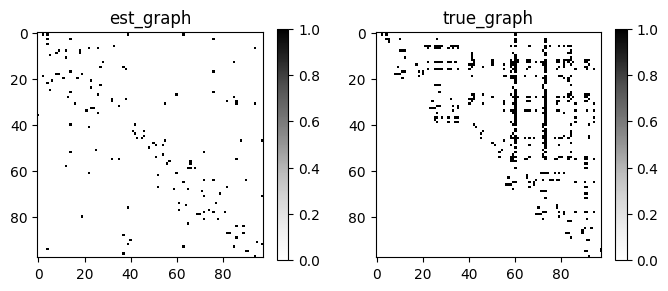

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


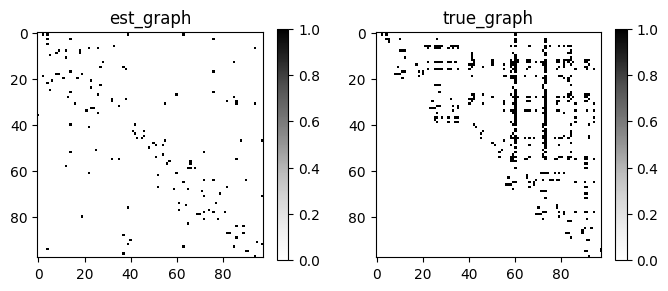

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


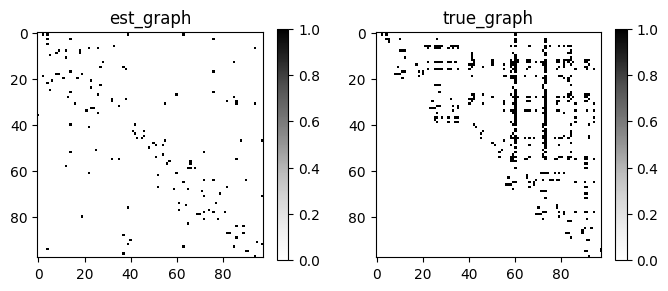

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


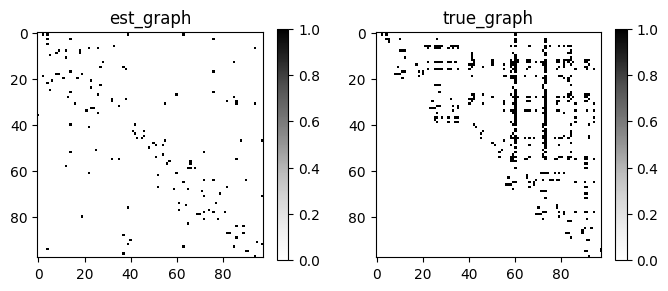

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


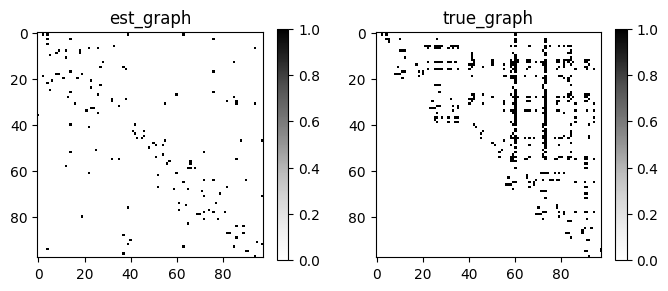

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


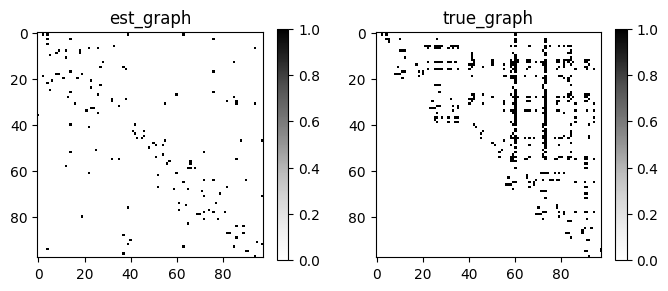

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


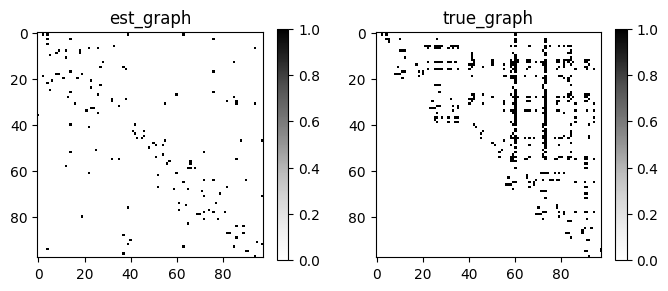

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


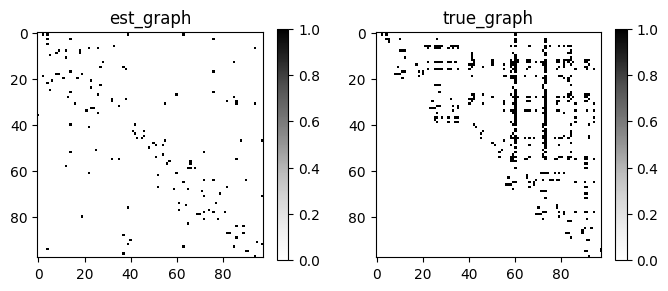

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


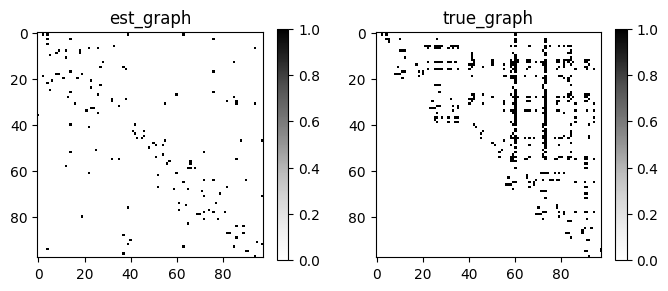

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


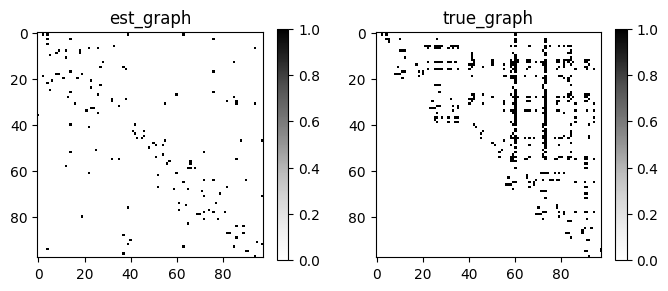

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


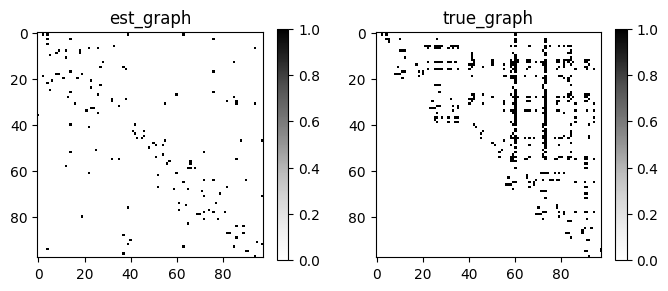

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


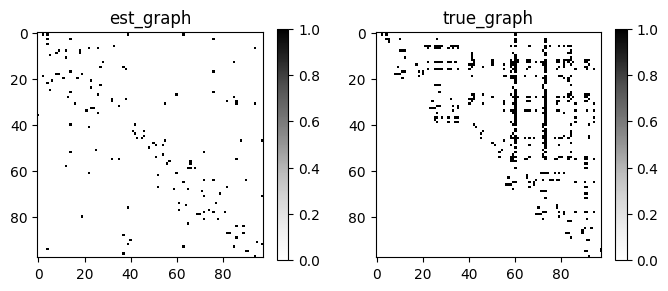

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


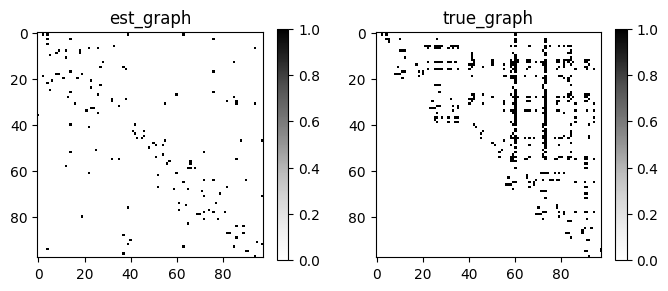

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


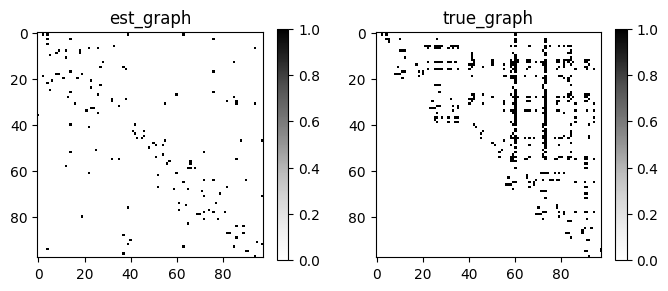

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


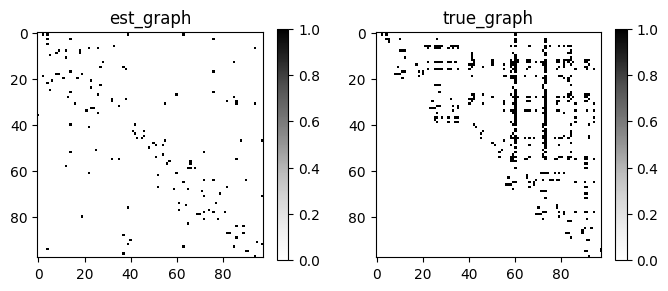

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


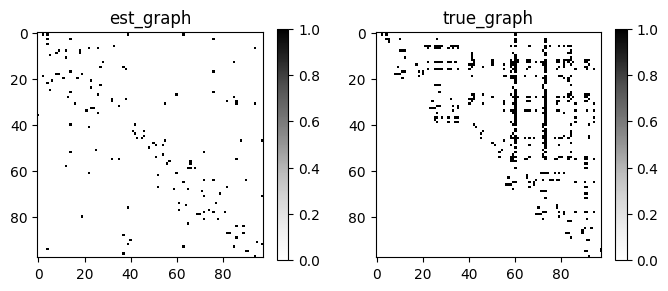

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


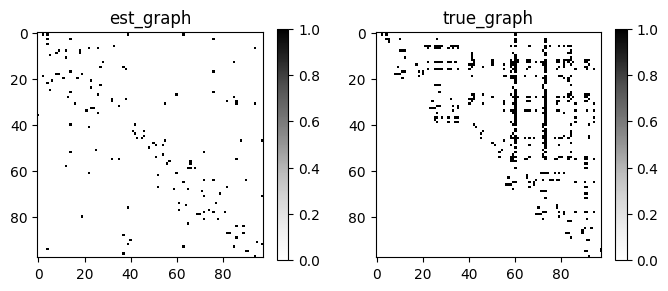

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


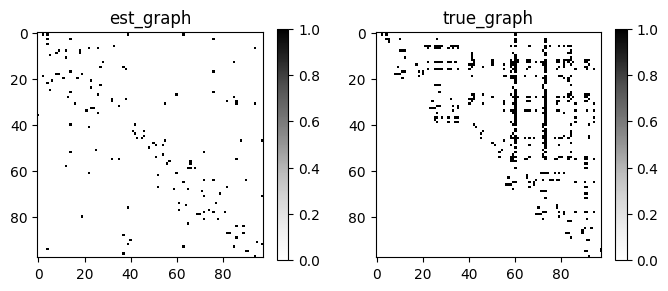

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


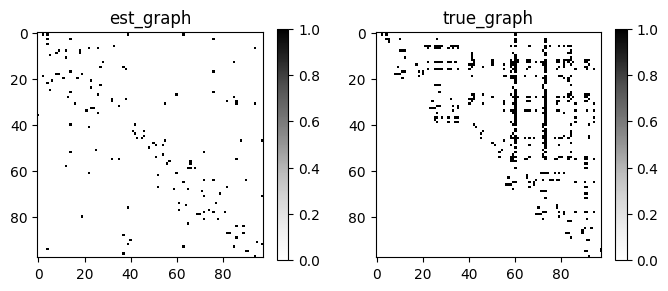

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


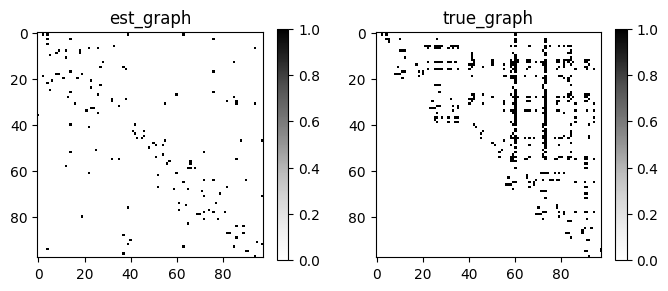

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


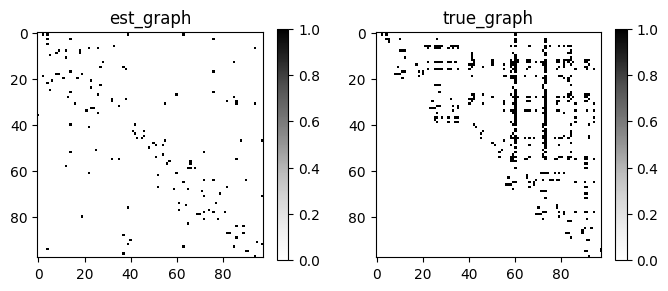

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


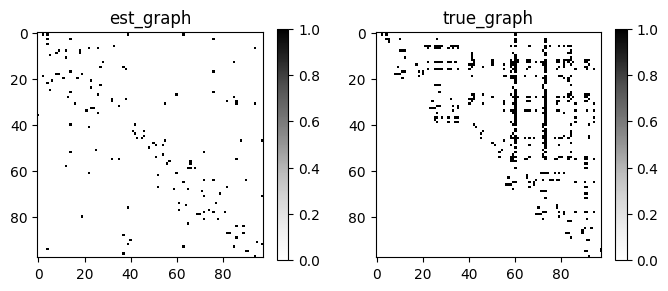

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


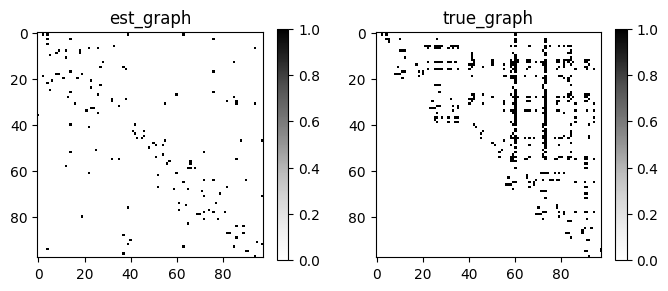

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


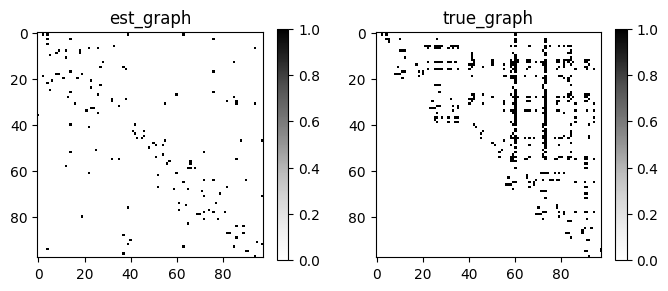

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


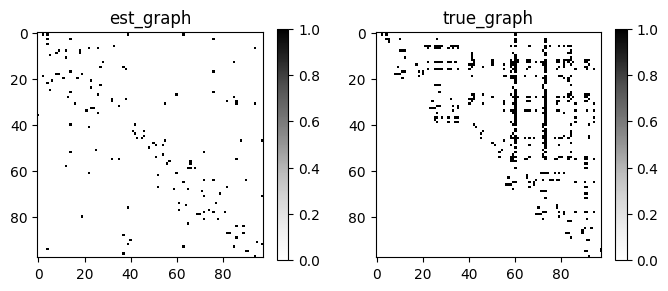

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


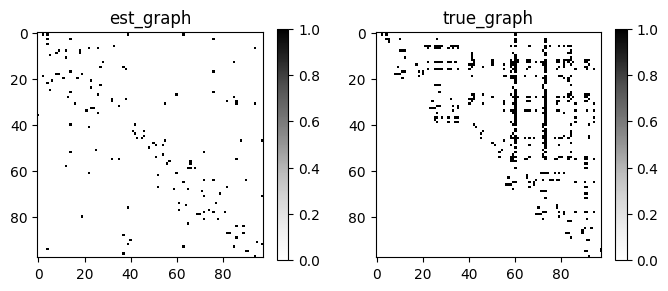

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


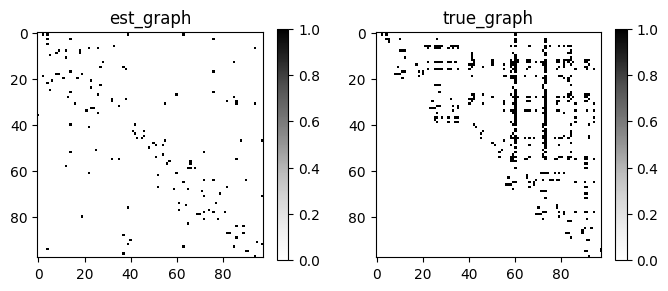

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


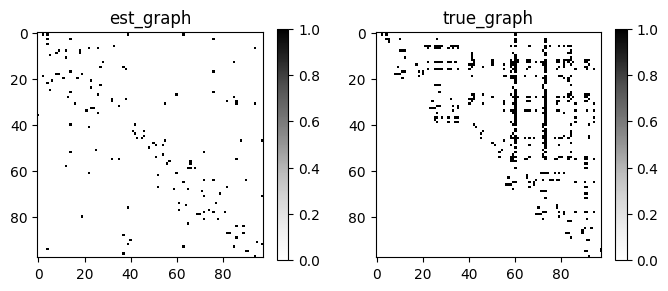

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


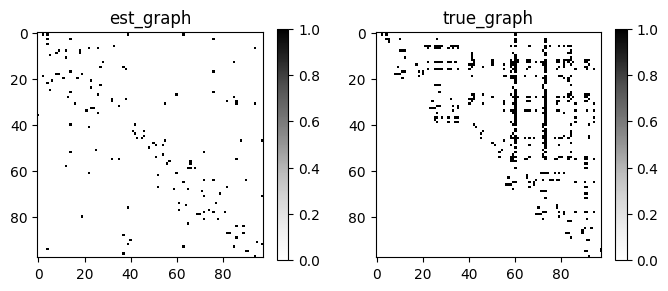

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


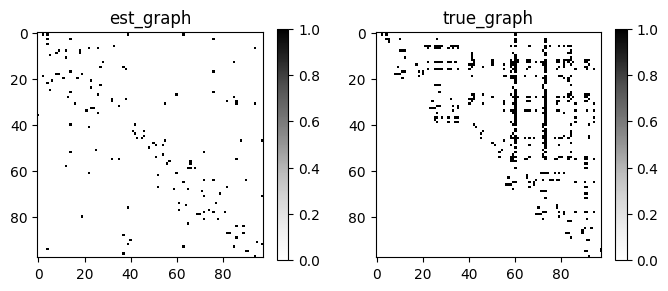

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


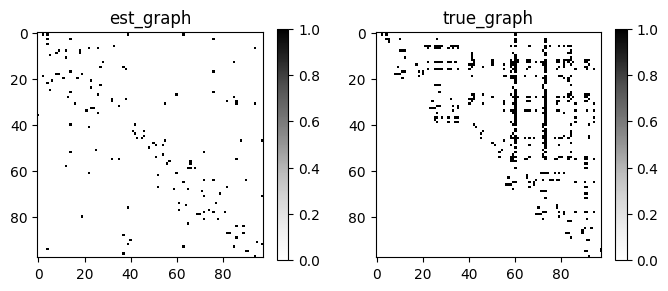

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


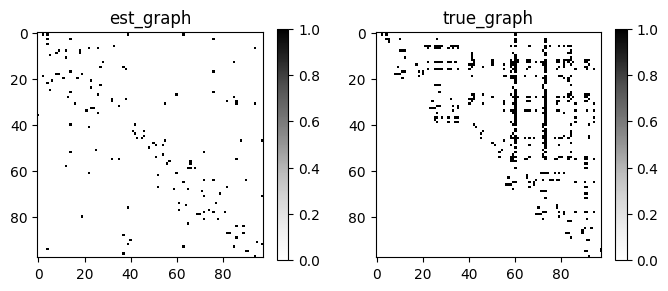

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


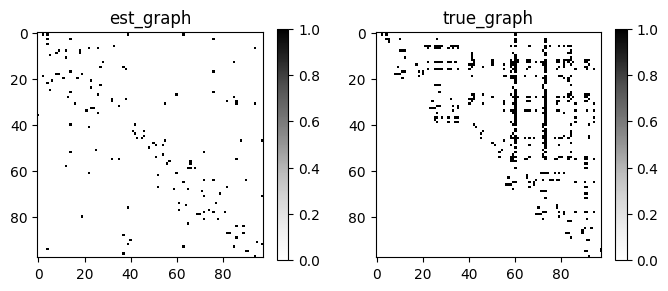

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


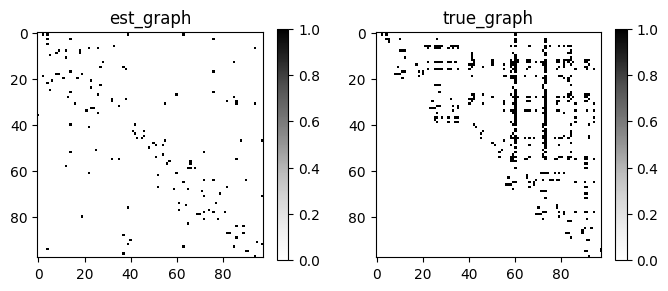

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


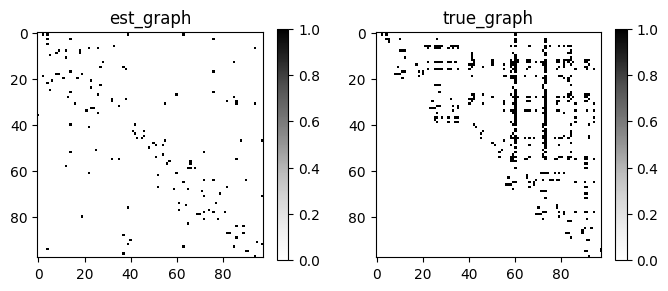

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


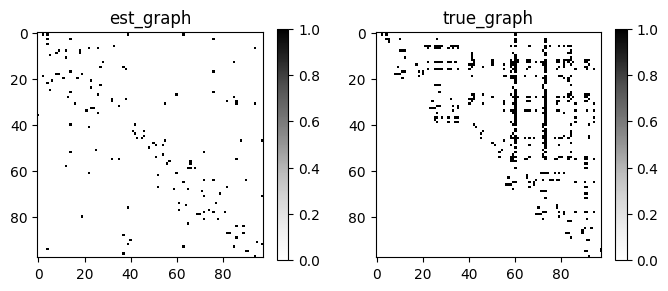

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


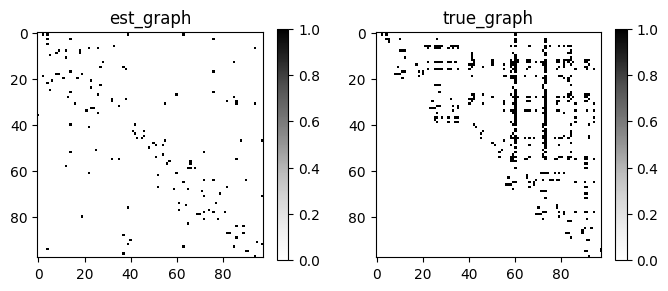

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


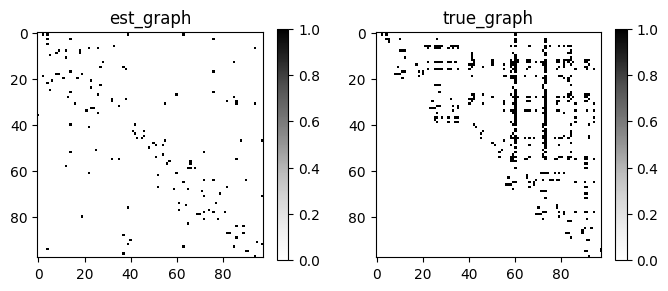

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


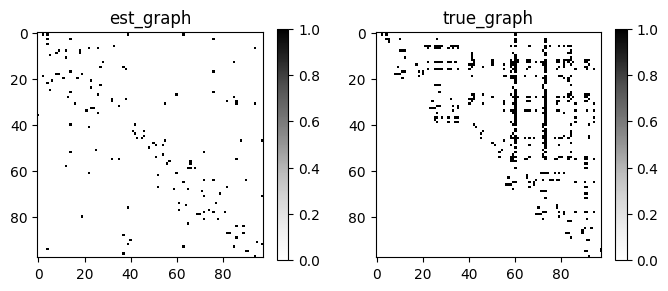

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


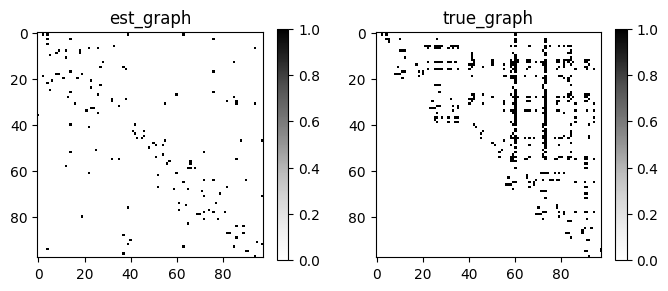

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


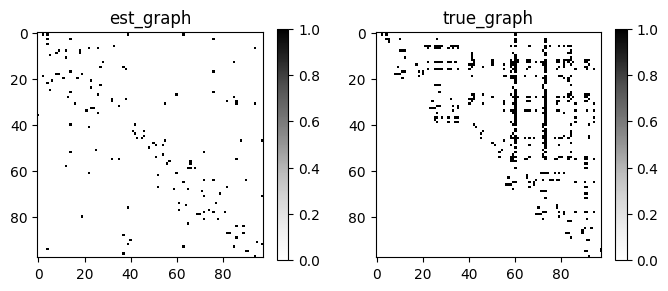

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


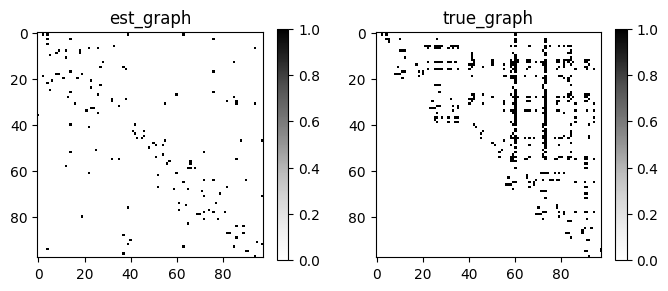

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


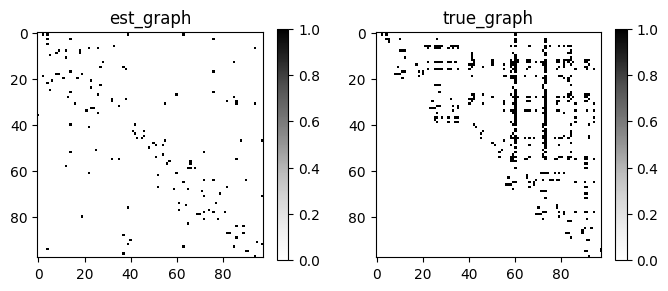

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


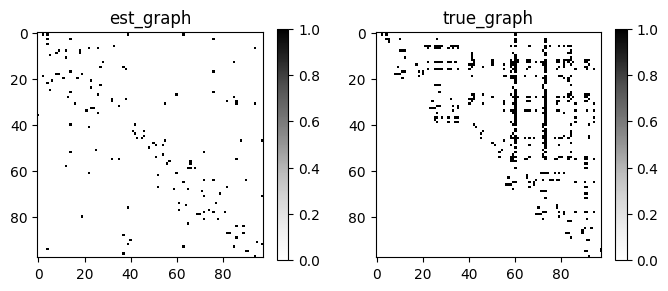

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


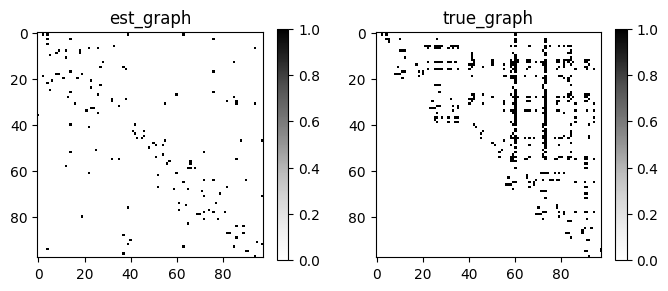

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


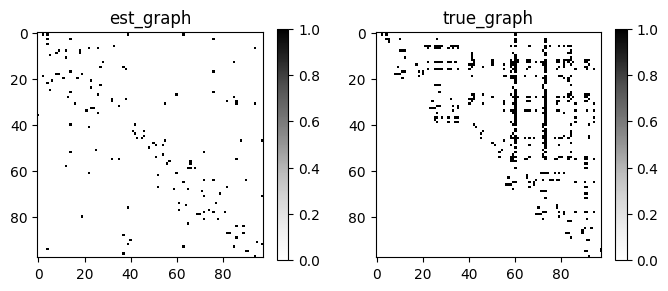

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


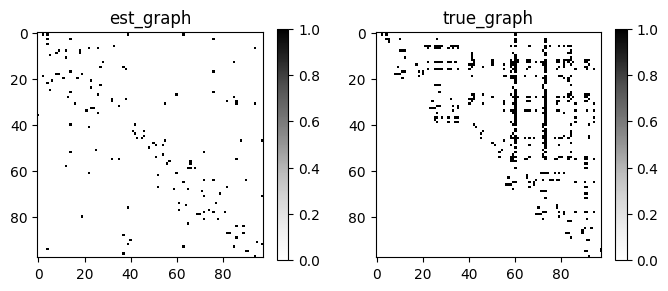

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


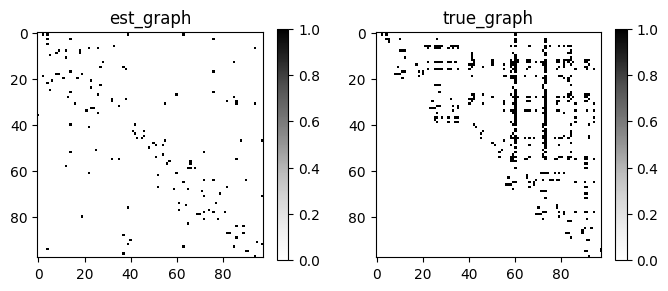

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


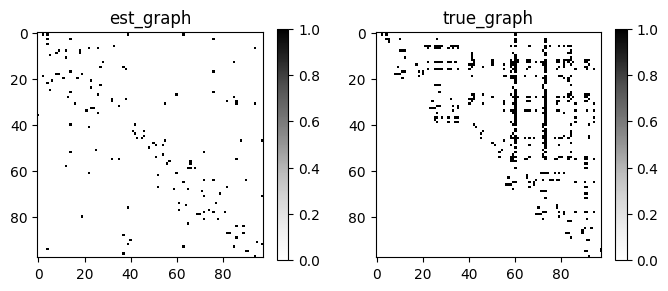

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


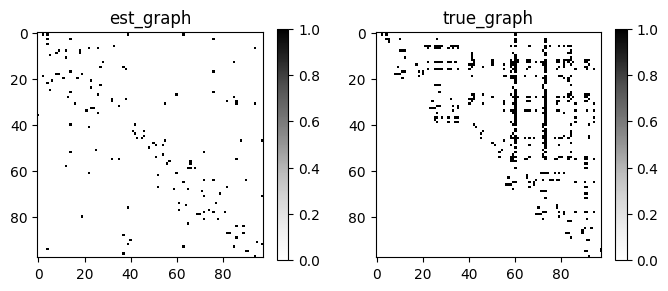

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


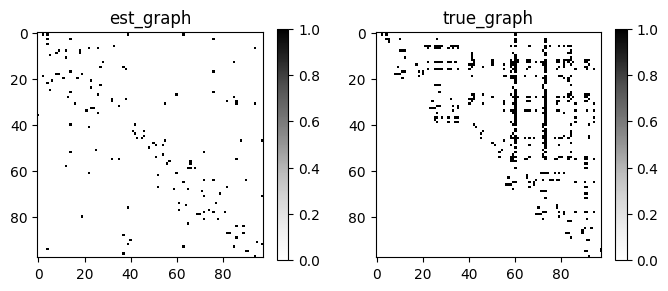

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


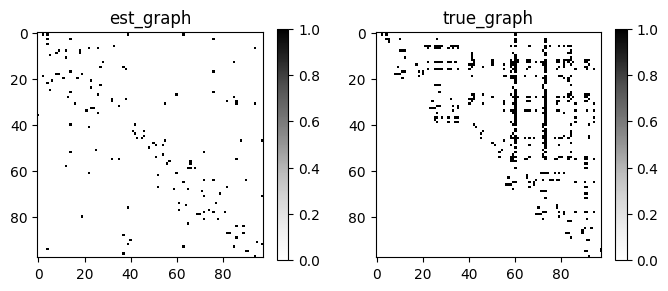

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


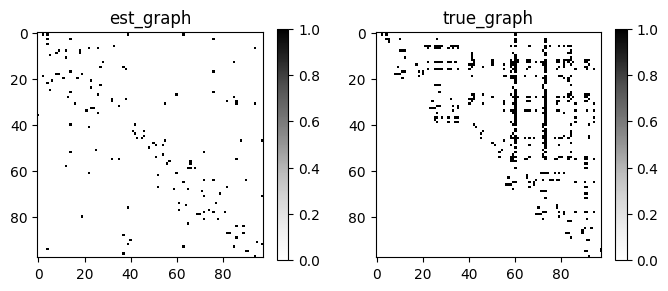

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


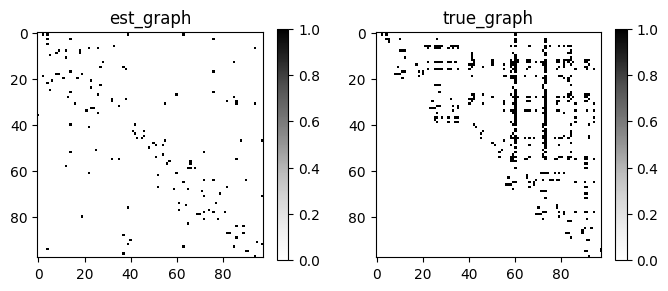

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


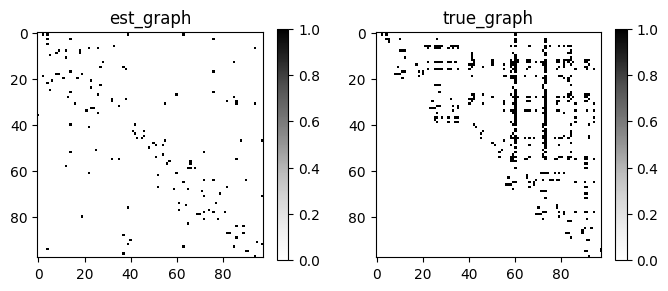

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.


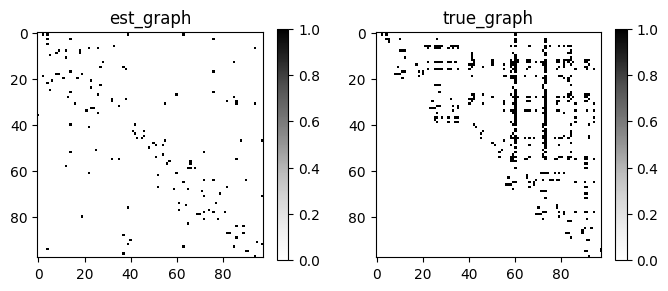

Results added to 'testing_results.csv'.


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [21]:
data = pd.read_csv('data/causalAssembly/demo_data/assembly_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/assembly_line_ground_truth.csv').to_numpy()


for i in range (1,101):
    pc = PC(variant = 'stable')
    start_time = time.time()
    pc.learn(data)
    end_time = time.time()
    runtime = end_time - start_time

    GraphDAG(pc.causal_matrix, ground_truth)
    met = MetricsDAG(pc.causal_matrix, ground_truth)
    add_results('causalAssembly', 'assembly_line', 500, 'PC', runtime, None, met.metrics)
# print(met.metrics)

### station3

#### sample size 500

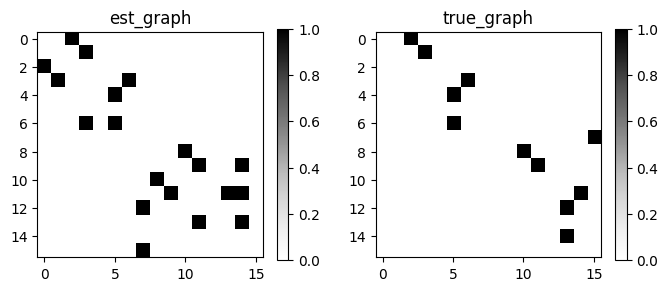

Results added to 'testing_results.csv'.
{'fdr': 0.3846, 'tpr': 0.7273, 'fpr': 0.0459, 'shd': 6, 'nnz': 13, 'precision': 0.4211, 'recall': 0.7273, 'F1': 0.5333, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [24]:
data = pd.read_csv('data/causalAssembly/demo_data/station3_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/station3_ground_truth.csv').to_numpy()

pc = PC(variant = 'stable')
start_time = time.time()
pc.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(pc.causal_matrix, ground_truth)
met = MetricsDAG(pc.causal_matrix, ground_truth)
add_results('causalAssembly', 'demo_station3', 500, 'PC', runtime, None, met.metrics)
print(met.metrics)

#### sample size 2000

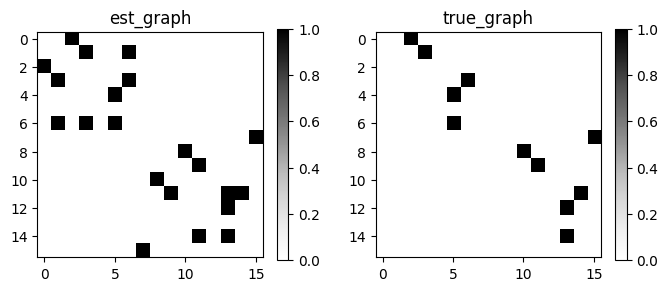

Results added to 'testing_results.csv'.
{'fdr': 0.1538, 'tpr': 1.0, 'fpr': 0.0183, 'shd': 2, 'nnz': 13, 'precision': 0.5238, 'recall': 1.0, 'F1': 0.6875, 'gscore': 0.0909}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [25]:
data = pd.read_csv('data/causalAssembly/demo_data/station3_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/demo_data/station3_ground_truth.csv').to_numpy()

pc = PC(variant = 'stable')
start_time = time.time()
pc.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(pc.causal_matrix, ground_truth)
met = MetricsDAG(pc.causal_matrix, ground_truth)
add_results('causalAssembly', 'demo_station3', 2000, 'PC', runtime, None, met.metrics)
print(met.metrics)

## custom_line

requirements:

3-cell production process

cell_1: 34-40 characteristics (boolean), resembling the vehicle characteristics (originally 670, but correlation analysis limited this to 34-40 relevant ones)

cell_2: 2 characteristics: mean ergonomics and duration. Both are contiunous, but could be binned.
    idea: get continuous data for each and then bin it into 4 bins

cell_3: 1 charactreristic: defect (boolean)


++++++++++++ 
this was falsely implemnted with 2 characteristics in cell_3
++++++++++++

only forward-reaching connections possible from cell i to i+1


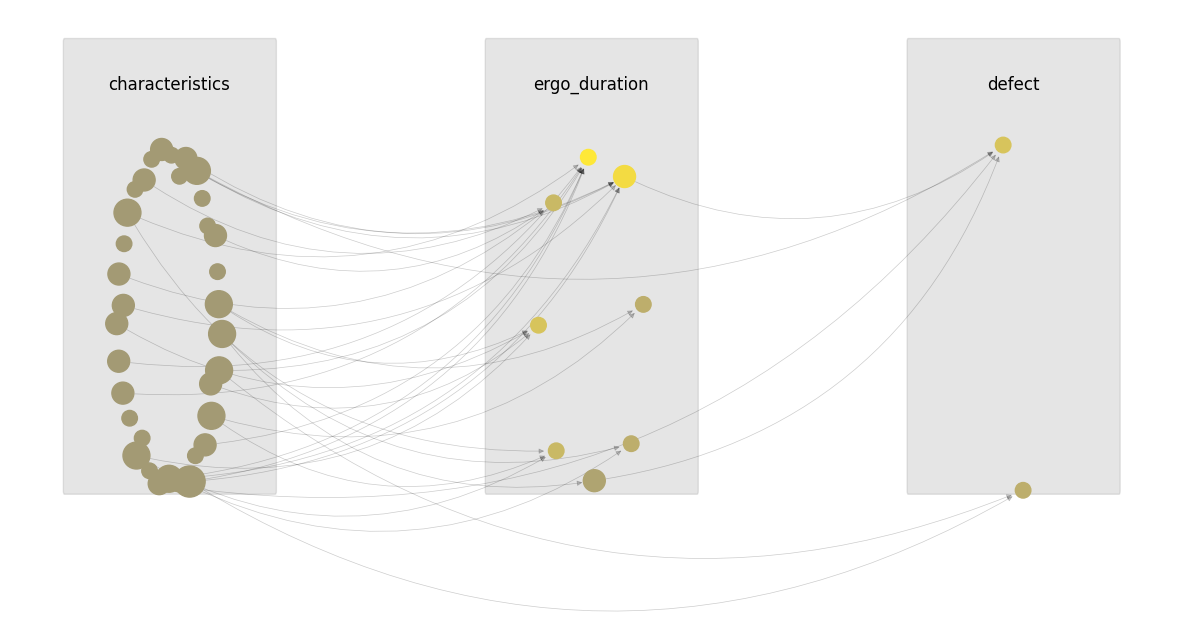

In [144]:
### CREATE GRAPH

custom_line = ProductionLineGraph()

n_characteristics = 34
n_bins_ergo = 4
n_bins_dur = 4

## CELL_1

custom_line.new_cell(name='characteristics')
custom_line.characteristics.add_random_module(n_nodes=n_characteristics, p=0)

## CELL_2

custom_line.new_cell(name='ergo_duration')
# mean ergonomics
custom_line.ergo_duration.add_random_module(n_nodes=n_bins_ergo)
# mean duration
custom_line.ergo_duration.add_random_module(n_nodes=n_bins_dur)

## CELL_3

custom_line.new_cell(name='defect')
custom_line.defect.add_random_module(n_nodes=2)



### CREATE CONNECTIONS

custom_line.connect_cells(forward_probs=[0.1, 0.05])


custom_line.show()


Get data of same shape as custom_line adjacency matrix

In [146]:
#use the causalAssembly data for our own line
seed = 2023
n_select = 10000

cA_data = ProductionLineGraph.get_data()

#take subsample for demonstration purposes
cA_data = cA_data.sample(n_select, random_state=seed, replace=False)

# get first x columns of cA_data
custom_line_data = cA_data[cA_data.columns[:custom_line.ground_truth.shape[1]]]

# use the column names of our_line.ground truth to rename the columns of cA_data_2
custom_line_data.columns = custom_line.ground_truth.columns

create sample size 500

In [98]:
# use the drf algorithm to fit the data

custom_line.drf = fit_drf(custom_line, data=custom_line_data)
custom_line_sample = custom_line.sample_from_drf(size=500)
print(custom_line_sample.shape[0])

# save data to csv
custom_line.ground_truth.to_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv', index=False)
custom_line_sample.to_csv(f'data/causalAssembly/custom_line/custom_line_data_{custom_line_sample.shape[0]}.csv', index=False)

500


create sample size 1000

In [147]:
# use the drf algorithm to fit the data

custom_line.drf = fit_drf(custom_line, data=custom_line_data)
custom_line_sample = custom_line.sample_from_drf(size=1000)
print(custom_line_sample.shape[0])

# save data to csv
custom_line.ground_truth.to_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv', index=False)
custom_line_sample.to_csv(f'data/causalAssembly/custom_line/custom_line_data_{custom_line_sample.shape[0]}.csv', index=False)

1000


create sample size 2000

In [99]:
# use the drf algorithm to fit the data

custom_line.drf = fit_drf(custom_line, data=custom_line_data)
custom_line_sample = custom_line.sample_from_drf(size=2000)

# save data to csv
custom_line.ground_truth.to_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv', index=False)
custom_line_sample.to_csv(f'data/causalAssembly/custom_line/custom_line_data_{custom_line_sample.shape[0]}.csv', index=False)


create sample size 5000

In [100]:
# use the drf algorithm to fit the data

custom_line.drf = fit_drf(custom_line, data=custom_line_data)
custom_line_sample = custom_line.sample_from_drf(size=5000)
print(custom_line_sample.shape[0])

# save data to csv
custom_line.ground_truth.to_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv', index=False)
custom_line_sample.to_csv(f'data/causalAssembly/custom_line/custom_line_data_{custom_line_sample.shape[0]}.csv', index=False)

5000


create sample size 10000

In [149]:
# use the drf algorithm to fit the data

custom_line.drf = fit_drf(custom_line, data=custom_line_data)
custom_line_sample = custom_line.sample_from_drf(size=10000)
print(custom_line_sample.shape[0])

# save data to csv
custom_line.ground_truth.to_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv', index=False)
custom_line_sample.to_csv(f'data/causalAssembly/custom_line/custom_line_data_{custom_line_sample.shape[0]}.csv', index=False)

### DAG-MA

In [17]:
from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear

#### sample size 500

add data

In [23]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

model

In [24]:
model = DagmaLinear(loss_type='logistic')

start_time = time.time()
W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
end_time = time.time()
runtime = end_time - start_time

GraphDAG(W_est, ground_truth)
metrics = MetricsDAG(W_est, ground_truth)
add_results('custom_line', 'all', data.shape[0], 'DagmaLinear', runtime, None, metrics.metrics)
print(metrics.metrics)

 18%|█▊        | 198794/1120000.0 [17:37<1:21:41, 187.95it/s]


KeyboardInterrupt: 

### NOTEARS LINEAR

In [81]:
from castle.algorithms import Notears
from castle.datasets import load_dataset
from castle.common import GraphDAG
from castle.metrics import MetricsDAG

#### sample size 500

2024-06-25 14:03:29,122 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=500, d=44, iter_=100, h_=1e-08, rho_=1e+16
2024-06-25 14:03:29,256 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=5.735e-04, loss=4796405933049.488, rho=1.0e+00
2024-06-25 14:03:29,350 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=6.138e-04, loss=4706772632131.282, rho=1.0e+00
2024-06-25 14:03:29,442 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=6.138e-04, loss=4706772632131.282, rho=1.0e+01
2024-06-25 14:03:29,535 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[

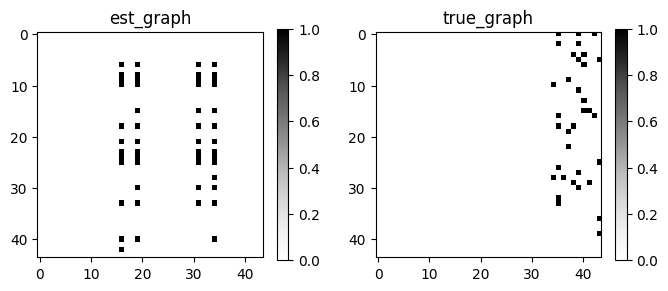

Results added to 'testing_results.csv'.
{'fdr': 0.9608, 'tpr': 0.0588, 'fpr': 0.0537, 'shd': 80, 'nnz': 51, 'precision': 0.0392, 'recall': 0.0588, 'F1': 0.0471, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [83]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

n = Notears()
start_time = time.time()
n.learn(data)
end_time = time.time()
runtime = end_time - start_time


GraphDAG(n.causal_matrix, ground_truth, save_name = 'test.png')
met = MetricsDAG(n.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', data.shape[0], 'NotearsLinear', runtime, None, met.metrics)
print(met.metrics)

#### sample size 2000

In [103]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

2024-06-24 12:54:33,098 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=44, iter_=100, h_=1e-08, rho_=1e+16
2024-06-24 12:54:33,288 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=3.292e-05, loss=4735202033247.224, rho=1.0e+00
2024-06-24 12:54:33,350 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=3.292e-05, loss=4709783958233.998, rho=1.0e+00
2024-06-24 12:54:33,412 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=3.292e-05, loss=4709783958233.998, rho=1.0e+01
2024-06-24 12:54:33,474 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py

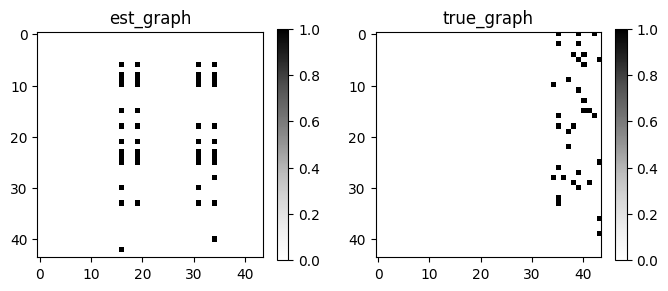

Results added to 'testing_results.csv'.
{'fdr': 0.9574, 'tpr': 0.0588, 'fpr': 0.0493, 'shd': 76, 'nnz': 47, 'precision': 0.0426, 'recall': 0.0588, 'F1': 0.0494, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [104]:
n = Notears()
start_time = time.time()
n.learn(data)
end_time = time.time()
runtime = end_time - start_time


GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', data.shape[0], 'NotearsLinear', runtime, None, met.metrics)
print(met.metrics)

#### sample size 5000

In [105]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_5000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

2024-06-24 12:54:40,312 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=5000, d=44, iter_=100, h_=1e-08, rho_=1e+16
2024-06-24 12:54:40,635 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=6.482e-06, loss=4688151559313.999, rho=1.0e+00
2024-06-24 12:54:40,714 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=6.483e-06, loss=4676221438983.528, rho=1.0e+00
2024-06-24 12:54:40,792 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 1] h=6.483e-06, loss=4676221438983.528, rho=1.0e+01
2024-06-24 12:54:40,868 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py

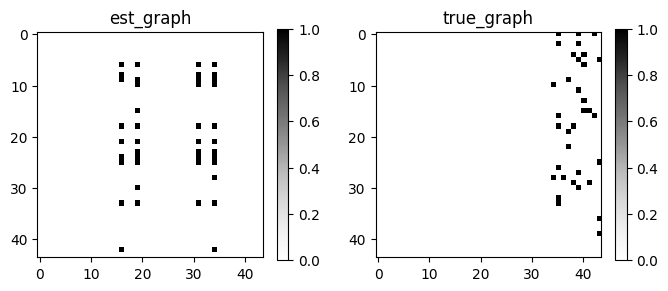

Results added to 'testing_results.csv'.
{'fdr': 0.9524, 'tpr': 0.0588, 'fpr': 0.0439, 'shd': 71, 'nnz': 42, 'precision': 0.0476, 'recall': 0.0588, 'F1': 0.0526, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [106]:
n = Notears()
start_time = time.time()
n.learn(data)
end_time = time.time()
runtime = end_time - start_time


GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', data.shape[0], 'NotearsLinear', runtime, None, met.metrics)
print(met.metrics)

### NOTEARS NON-LINEAR

In [111]:
from castle.algorithms import NotearsNonlinear

#### sample size 500

In [110]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

2024-06-24 12:55:09,344 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2024-06-24 12:55:09,405 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=500, d=44, iter_=100, h_=1e-08, rho_=1e+16
2024-06-24 12:56:27,908 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:249] - INFO: FINISHED


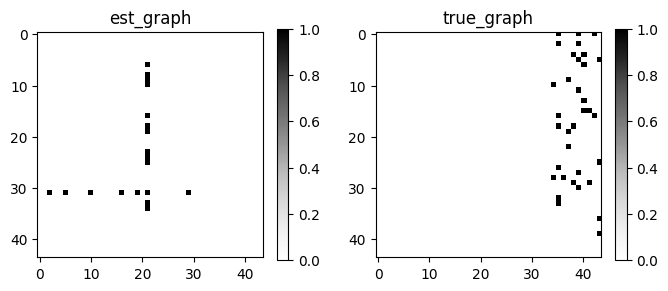

Results added to 'testing_results.csv'.
{'fdr': 1.0, 'tpr': 0.0, 'fpr': 0.0208, 'shd': 53, 'nnz': 19, 'precision': 0.0, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

In [112]:
n = NotearsNonlinear()
start_time = time.time()
n.learn(data)
end_time = time.time()
runtime = end_time - start_time


GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
# add the resulsts to the testing_results df
add_results('causalAssembly', 'custom_line', data.shape[0], 'NotearsNonLinear', runtime, None, met.metrics)
print(met.metrics)

#### sample size 2000

In [113]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

2024-06-24 12:57:11,729 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:135] - INFO: GPU is available.
2024-06-24 12:57:11,737 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:237] - INFO: [start]: n=2000, d=44, iter_=100, h_=1e-08, rho_=1e+16
2024-06-24 13:06:50,402 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/torch/nonlinear.py[line:249] - INFO: FINISHED


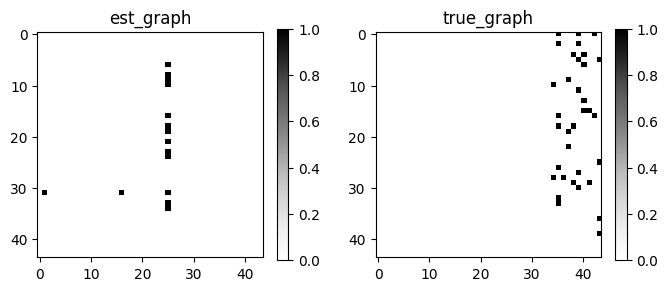

Results added to 'testing_results.csv'.
{'fdr': 1.0, 'tpr': 0.0, 'fpr': 0.0164, 'shd': 49, 'nnz': 15, 'precision': 0.0, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

In [114]:
n = NotearsNonlinear()
start_time = time.time()
n.learn(data)
end_time = time.time()
runtime = end_time - start_time


GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
# add the resulsts to the testing_results df
add_results('causalAssembly', 'custom_line', data.shape[0], 'NotearsNonLinear', runtime, None, met.metrics)
print(met.metrics)

#### sample size 5000

In [ ]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_5000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

In [ ]:
n = NotearsNonlinear()
start_time = time.time()
n.learn(data)
end_time = time.time()
runtime = end_time - start_time


GraphDAG(n.causal_matrix, ground_truth)
met = MetricsDAG(n.causal_matrix, ground_truth)
# add the resulsts to the testing_results df
add_results('causalAssembly', 'custom_line', data.shape[0], 'NotearsNonLinear', runtime, None, met.metrics)
print(met.metrics)

### PC

#### sample size 500

In [241]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

pc = PC(variant = 'stable')
start_time = time.time()
pc.learn(data)
end_time = time.time()
runtime = end_time - start_time


In [243]:
pc.causal_matrix.shape

(44, 44)

In [246]:
import numpy as np
import pandas as pd

# Convert the tensor to a list
tensor_list = pc.causal_matrix.tolist()

# Get the shape of the tensor
tensor_shape = pc.causal_matrix.shape

# Convert the list to a NumPy array and reshape it
causal_matrix = np.array(tensor_list).reshape(tensor_shape)

# Convert the NumPy array to a DataFrame and save it as a CSV file
causal_df = pd.DataFrame(causal_matrix)
causal_df.to_csv('test.csv', index=False)


In [249]:
df = pd.DataFrame(np.array(pc.causal_matrix.tolist()).reshape(pc.causal_matrix.shape))
df.to_csv('test.csv', index=False)

In [230]:
plot_heatmap()

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__r

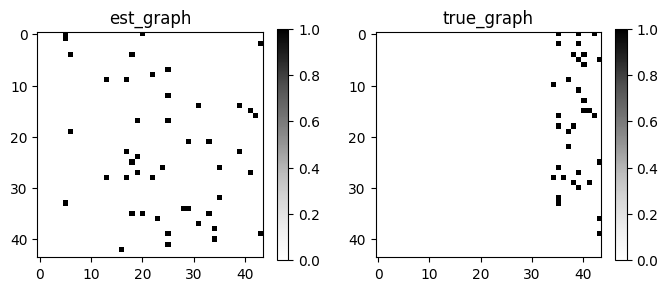

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


AttributeError: 'Tensor' object has no attribute 'values'

In [229]:

GraphDAG(pc.causal_matrix, ground_truth)
met = MetricsDAG(pc.causal_matrix, ground_truth)
# plot_heatmap(pc.causal_matrix, method = 'PC', save_name = 'test.png')
causal_matrix = pc.causal_matrix.values
causal_matrix.to_csv('test.csv', index=False)
add_results('causalAssembly', 'custom_line', 500, 'PC', runtime, None, met.metrics)
print(met.metrics)

#### sample size 2000

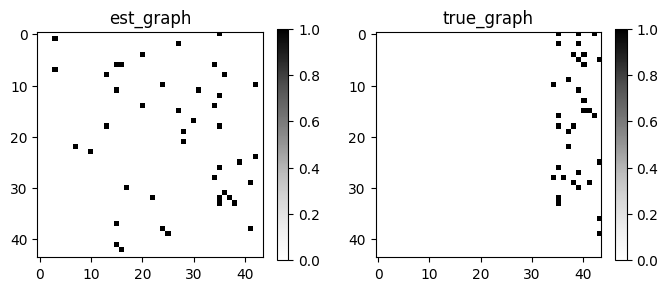

Results added to 'testing_results.csv'.
{'fdr': 0.8293, 'tpr': 0.2059, 'fpr': 0.0373, 'shd': 59, 'nnz': 41, 'precision': 0.1628, 'recall': 0.2059, 'F1': 0.1818, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [29]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

pc = PC(variant = 'stable')
start_time = time.time()
pc.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(pc.causal_matrix, ground_truth)
met = MetricsDAG(pc.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', 2000, 'PC', runtime, None, met.metrics)
print(met.metrics)

#### sample size 5000

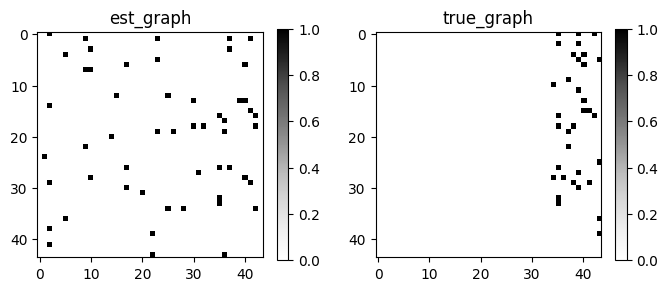

Results added to 'testing_results.csv'.
{'fdr': 0.8302, 'tpr': 0.2647, 'fpr': 0.0482, 'shd': 67, 'nnz': 53, 'precision': 0.1698, 'recall': 0.2647, 'F1': 0.2069, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [30]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_5000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

pc = PC(variant = 'stable')
start_time = time.time()
pc.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(pc.causal_matrix, ground_truth)
met = MetricsDAG(pc.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', 5000, 'PC', runtime, None, met.metrics)
print(met.metrics)

### DIRECT LINGAM

In [33]:
from castle.algorithms import DirectLiNGAM

#### sample size 500

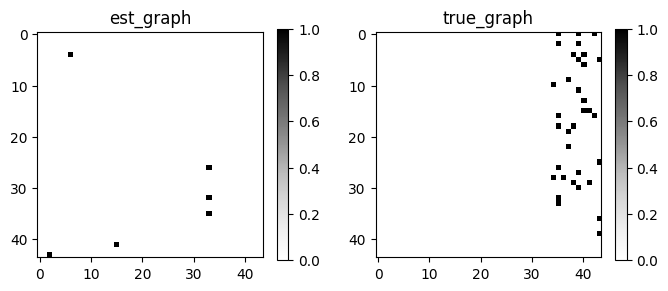

Results added to 'testing_results.csv'.
{'fdr': 1.0, 'tpr': 0.0, 'fpr': 0.0066, 'shd': 38, 'nnz': 6, 'precision': 0.0, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

In [34]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_500.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

l = DirectLiNGAM()
start_time = time.time()
l.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(l.causal_matrix, ground_truth)
met = MetricsDAG(l.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', 500, 'DirectLINGAM', runtime, None, met.metrics)
print(met.metrics)

#### sample size 2000

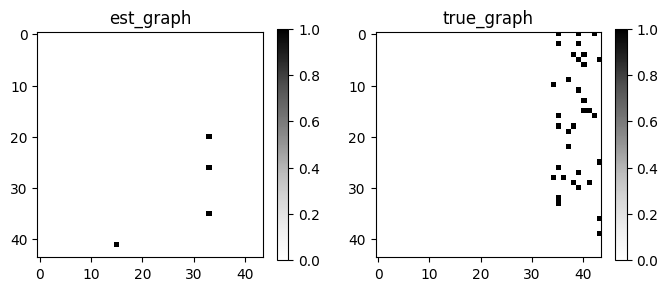

Results added to 'testing_results.csv'.
{'fdr': 1.0, 'tpr': 0.0, 'fpr': 0.0044, 'shd': 36, 'nnz': 4, 'precision': 0.0, 'recall': 0.0, 'F1': nan, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

In [37]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_2000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

l = DirectLiNGAM()
start_time = time.time()
l.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(l.causal_matrix, ground_truth)
met = MetricsDAG(l.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', data.shape[0] , 'DirectLINGAM', runtime, None, met.metrics)
print(met.metrics)

#### sample size 5000

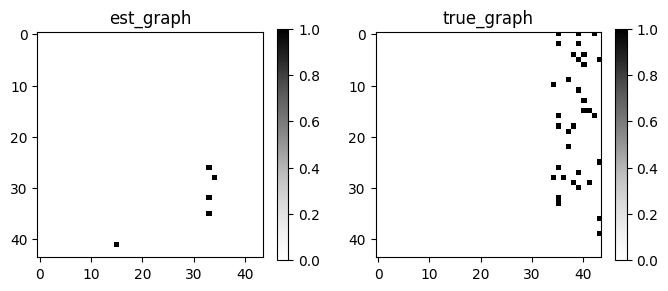

Results added to 'testing_results.csv'.
{'fdr': 0.8, 'tpr': 0.0294, 'fpr': 0.0044, 'shd': 35, 'nnz': 5, 'precision': 0.2, 'recall': 0.0294, 'F1': 0.0513, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [38]:
data = pd.read_csv('data/causalAssembly/custom_line/custom_line_data_5000.csv').to_numpy()
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

l = DirectLiNGAM()
start_time = time.time()
l.learn(data)
end_time = time.time()
runtime = end_time - start_time

GraphDAG(l.causal_matrix, ground_truth)
met = MetricsDAG(l.causal_matrix, ground_truth)
add_results('causalAssembly', 'custom_line', data.shape[0] , 'DirectLINGAM', runtime, None, met.metrics)
print(met.metrics)

### ICA LINGAM

In [40]:
from castle.algorithms import ICALiNGAM

#### all sample sizes

Sample size: 500 | runtime: 5.783263444900513 sec


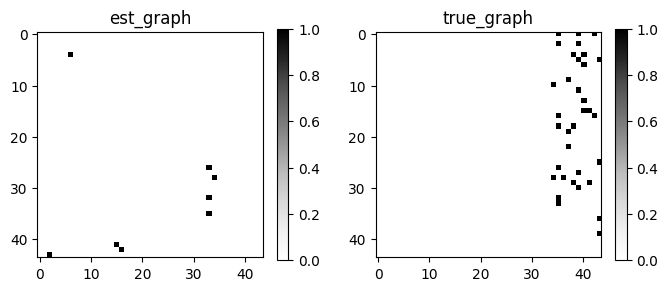

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.
{'fdr': 0.875, 'tpr': 0.0294, 'fpr': 0.0077, 'shd': 37, 'nnz': 8, 'precision': 0.125, 'recall': 0.0294, 'F1': 0.0476, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Sample size: 2000 | runtime: 10.129598617553711 sec


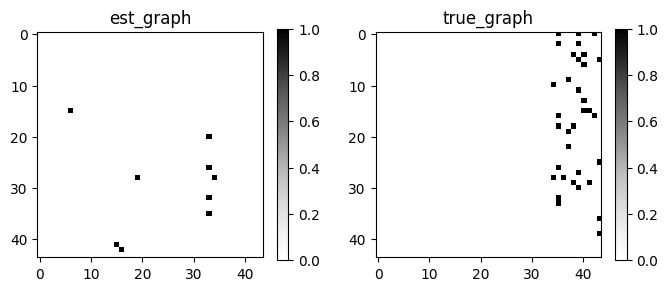

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


Results added to 'testing_results.csv'.
{'fdr': 0.8889, 'tpr': 0.0294, 'fpr': 0.0088, 'shd': 38, 'nnz': 9, 'precision': 0.1111, 'recall': 0.0294, 'F1': 0.0465, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Sample size: 5000 | runtime: 15.644242525100708 sec


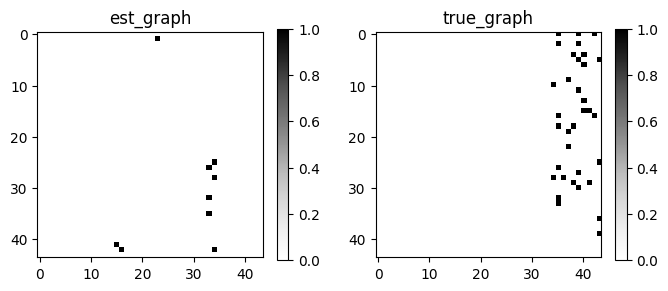

Results added to 'testing_results.csv'.
{'fdr': 0.8889, 'tpr': 0.0294, 'fpr': 0.0088, 'shd': 38, 'nnz': 9, 'precision': 0.1111, 'recall': 0.0294, 'F1': 0.0465, 'gscore': 0.0}


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


In [41]:
sample_sizes = [500, 2000, 5000]

for sample_size in sample_sizes:
    data = pd.read_csv(f'data/causalAssembly/custom_line/custom_line_data_{sample_size}.csv').to_numpy()
    ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

    l = ICALiNGAM()
    start_time = time.time()
    l.learn(data)
    end_time = time.time()
    runtime = end_time - start_time

    print(f"Sample size: {sample_size} | runtime: {runtime} sec")
    GraphDAG(l.causal_matrix, ground_truth)
    met = MetricsDAG(l.causal_matrix, ground_truth)
    add_results('causalAssembly', 'custom_line', sample_size, 'ICALiNGAM', runtime, None, met.metrics)
    print(met.metrics)

### TESTS

In [1]:
from castle.algorithms import Notears
from dagma.linear import DagmaLinear
from castle.algorithms import GAE
from castle.algorithms import DirectLiNGAM
from castle.algorithms import PC

/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-25 18:03:55,444 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-06-25 18:03:55,504 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [33]:
algorithms = [
    # 'NotearsLinear'
    # ,'DagmaLinear'
    'GAE'
    , 'DirectLiNGAM'
    , 'PC'
    ]

sample_sizes_cA_custom_line = [500, 1000, 2000, 5000, 10000]

In [34]:
sample_sizes_cA_custom_line[1:2]

[1000]

2024-06-26 07:55:15,548 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-26 07:55:15,550 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-26 07:55:15,559 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 748378394729848.4


2024-06-26 07:55:16,622 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 732013243302691.2
2024-06-26 07:55:17,697 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 400: 71378503980738.8
2024-06-26 07:55:18,776 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 600: 7246307158114.582
2024-06-26 07:55:19,851 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 800: 7142505636291.711
2024-06-26 07:55:20,925 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/t

GAE_1000


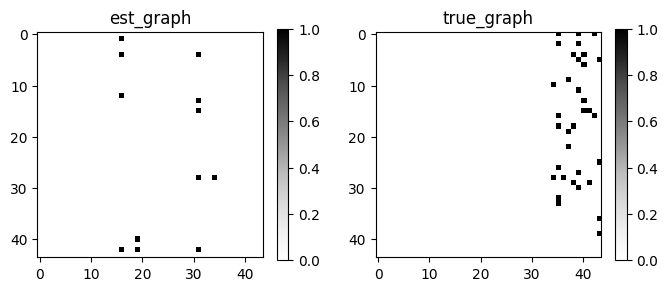

Results added to 'testing_results.csv'.
DirectLiNGAM_1000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

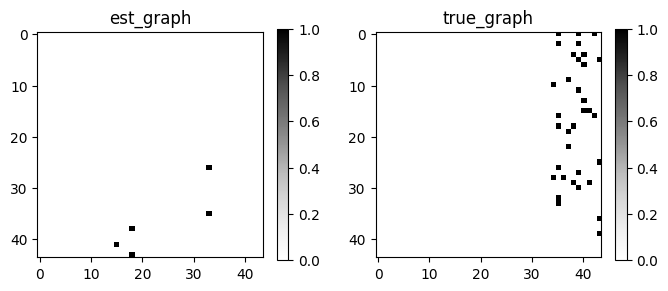

Results added to 'testing_results.csv'.
PC_1000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


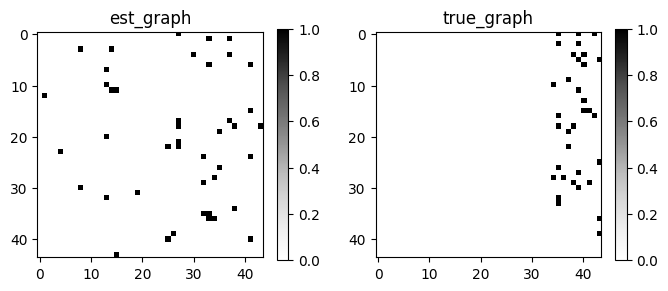

Results added to 'testing_results.csv'.


In [35]:
ground_truth = pd.read_csv('data/causalAssembly/custom_line/custom_line_ground_truth.csv').to_numpy()

sample_sizes_cA_custom_line = sample_sizes_cA_custom_line[1:2]

# go over sample sizes
for sample_size in sample_sizes_cA_custom_line:

    data = pd.read_csv(f'data/causalAssembly/custom_line/custom_line_data_{sample_size}.csv').to_numpy()

    # go over all algorithms
    for algorithm in algorithms:
        
        # set different params for the different models
        match algorithm:

            case 'NotearsLinear':
                model = Notears()
                start_time = time.time()
                model.learn(data)
                end_time = time.time()             

            case 'DagmaLinear':
                model = DagmaLinear(loss_type='logistic')
                start_time = time.time()
                W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
                end_time = time.time()
                
            case 'GAE':
                model = GAE(epochs=3)
                start_time = time.time()
                model.learn(data)
                end_time = time.time()

            case 'DirectLiNGAM':
                model = DirectLiNGAM()
                start_time = time.time()
                model.learn(data)
                end_time = time.time()

            case 'PC':
                model = PC(variant = 'stable')
                start_time = time.time()
                model.learn(data)
                end_time = time.time()
                               
                
             
        # calculate runtime
        runtime = end_time - start_time
    
        # plot comparison graph
        name = f'{algorithm}_{sample_size}'
        print(name)
        save_name = f'plots/adj_matrix/causalAssembly/custom_line/{name}.png'

        match algorithm:
            case 'NotearsLinear':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'DagmaLinear':
                met = MetricsDAG(W_est, ground_truth)
                GraphDAG(W_est, ground_truth, save_name = save_name)
            case 'GAE':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'DirectLiNGAM':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'PC':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
        
        # save metrics to csv
        add_results('causalAssembly', 'custom_line', sample_size, algorithm, runtime, None, met.metrics) 


## custom_line2

requirements:

3-cell production process

cell_1: 34-40 characteristics (boolean), resembling the vehicle characteristics (originally 670, but correlation analysis limited this to 34-40 relevant ones)

cell_2: 2 characteristics: mean ergonomics and duration. Both are contiunous, but could be binned.
    idea: get continuous data for each and then bin it into 4 bins

cell_3: 1 charactreristic: defect (boolean)

only forward-reaching connections possible from cell i to i+1


### only for displaying the right cell names

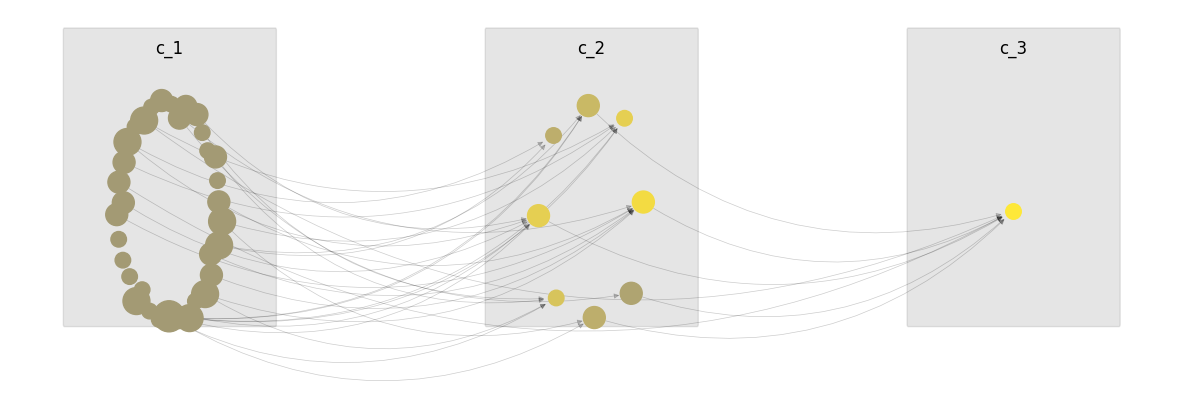

In [69]:
### CREATE GRAPH

custom_line2 = ProductionLineGraph()

n_characteristics = 34
n_bins_ergo = 4
n_bins_dur = 4

## CELL_1

custom_line2.new_cell(name='c_1')
custom_line2.c_1.add_random_module(n_nodes=n_characteristics, p=0)

## CELL_2

custom_line2.new_cell(name='c_2')
# mean ergonomics
custom_line2.c_2.add_random_module(n_nodes=n_bins_ergo)
# mean duration
custom_line2.c_2.add_random_module(n_nodes=n_bins_dur)

## CELL_3

custom_line2.new_cell(name='c_3')
custom_line2.c_3.add_random_module(n_nodes=1)



### CREATE CONNECTIONS

# connections with default values
custom_line2.connect_cells(forward_probs=[0.1, 0.05])

# adjusted for more connections from cell2 to cell3
edges = []

# create semi random connections
import random
random.seed(40)

probs = []

for node in range (1, n_bins_ergo+n_bins_dur+1):
    probs.append(random.randint(1,100)/100)


# create connection of prob > 0.5
for node in range(0, n_bins_ergo):
    if probs[node] > 0.5:
        edges.append((f'c_2_M1_{node}', 'c_3_M1_0')) # M1 for ergo module

for node in range(0, n_bins_dur):
    if probs[node + n_bins_ergo] > 0.5:
        edges.append((f'c_2_M2_{node}', 'c_3_M1_0')) # M2 for duration module

custom_line2.connect_across_cells_manually(edges) 


custom_line2.show(fig_size=(15,5))


### true creation

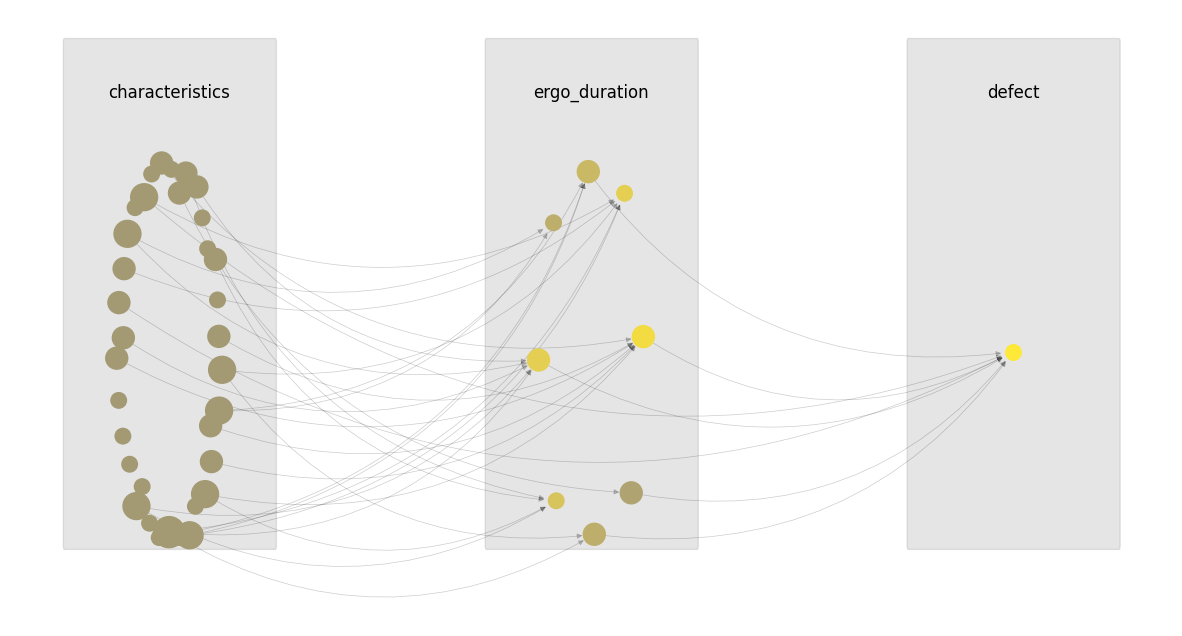

In [65]:
### CREATE GRAPH

custom_line2 = ProductionLineGraph()

n_characteristics = 34
n_bins_ergo = 4
n_bins_dur = 4

## CELL_1

custom_line2.new_cell(name='characteristics')
custom_line2.characteristics.add_random_module(n_nodes=n_characteristics, p=0)

## CELL_2

custom_line2.new_cell(name='ergo_duration')
# mean ergonomics
custom_line2.ergo_duration.add_random_module(n_nodes=n_bins_ergo)
# mean duration
custom_line2.ergo_duration.add_random_module(n_nodes=n_bins_dur)

## CELL_3

custom_line2.new_cell(name='defect')
custom_line2.defect.add_random_module(n_nodes=1)



### CREATE CONNECTIONS

# connections with default values
custom_line2.connect_cells(forward_probs=[0.1, 0.05])

# adjusted for more connections from cell2 to cell3
edges = []

# create semi random connections
import random
random.seed(40)

probs = []

for node in range (1, n_bins_ergo+n_bins_dur+1):
    probs.append(random.randint(1,100)/100)


# create connection of prob > 0.5
for node in range(0, n_bins_ergo):
    if probs[node] > 0.5:
        edges.append((f'ergo_duration_M1_{node}', 'defect_M1_0')) # M1 for ergo module

for node in range(0, n_bins_dur):
    if probs[node + n_bins_ergo] > 0.5:
        edges.append((f'ergo_duration_M2_{node}', 'defect_M1_0')) # M2 for duration module

custom_line2.connect_across_cells_manually(edges) 


custom_line2.show()


In [4]:
#use the causalAssembly data for our own line
seed = 2023
n_select = 10000

cA_data = ProductionLineGraph.get_data()

#take subsample for demonstration purposes
cA_data = cA_data.sample(n_select, random_state=seed, replace=False)

# get first x columns of cA_data
custom_line2_data = cA_data[cA_data.columns[:custom_line2.ground_truth.shape[1]]]

# use the column names of our_line.ground truth to rename the columns of cA_data_2
custom_line2_data.columns = custom_line2.ground_truth.columns

In [5]:
custom_line2_sample_sizes = [500, 1000, 2000, 5000, 10000]

for sample_size in custom_line2_sample_sizes:

    # use the drf algorithm to fit the data

    custom_line2.drf = fit_drf(custom_line2, data=custom_line2_data)
    custom_line2_sample = custom_line2.sample_from_drf(size=sample_size)
    print(custom_line2_sample.shape[0])

    # save data to csv
    custom_line2.ground_truth.to_csv('data/causalAssembly/custom_line2/custom_line2_ground_truth.csv', index=False)
    custom_line2_sample.to_csv(f'data/causalAssembly/custom_line2/custom_line2_data_{custom_line2_sample.shape[0]}.csv', index=False)

500
1000
2000
5000
10000


create figure

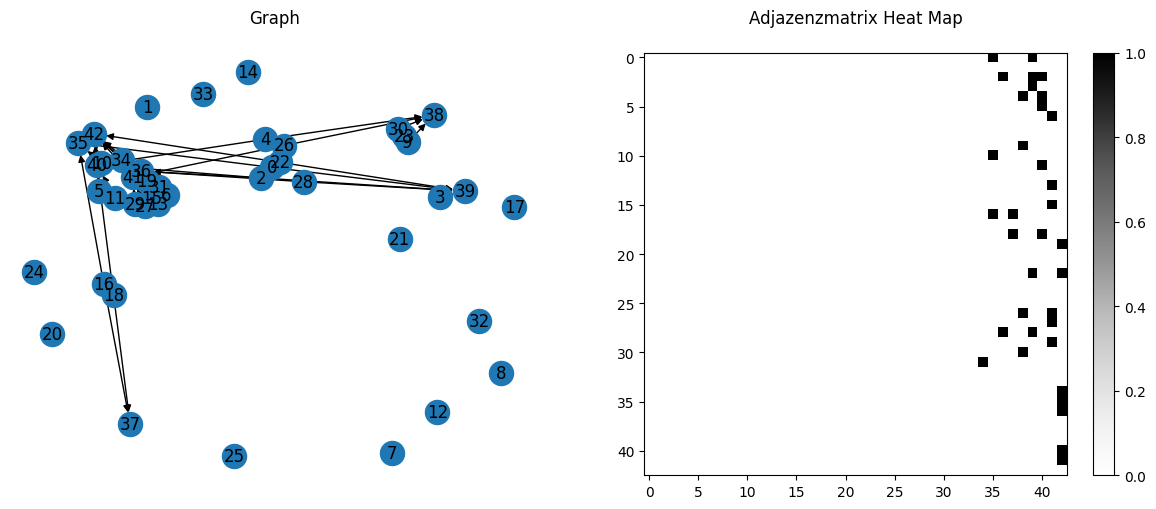

In [70]:
ground_truth = pd.read_csv('data/causalAssembly/custom_line2/custom_line2_ground_truth.csv').to_numpy()
save_name = 'plots/adj_matrix/causalAssembly/custom_line2/ground_truth.png'
plot_graph_adjacency_matrix(ground_truth, save_name)

### TESTS

In [71]:
from castle.algorithms import Notears
from dagma.linear import DagmaLinear
from castle.algorithms import GAE
from castle.algorithms import DirectLiNGAM
from castle.algorithms import PC

In [72]:
algorithms = [
    # 'NotearsLinear'
    # ,'DagmaLinear'
    'GAE'
    , 'DirectLiNGAM'
    , 'PC'
    ]

sample_sizes_cA_custom_line2 = [500, 1000, 2000, 5000, 10000]

2024-06-27 07:27:55,647 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-27 07:27:55,649 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-27 07:27:55,692 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 741511278241248.0


2024-06-27 07:28:01,086 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 577945172056157.8
2024-06-27 07:28:06,621 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 400: 7262186282822.9375
2024-06-27 07:28:12,027 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 600: 7202231287042.431
2024-06-27 07:28:17,487 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 800: 7156403188407.384
2024-06-27 07:28:22,977 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch

GAE_10000


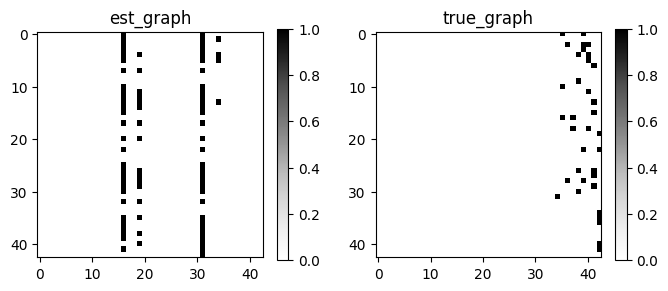

Results added to 'testing_results.csv'.
DirectLiNGAM_10000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


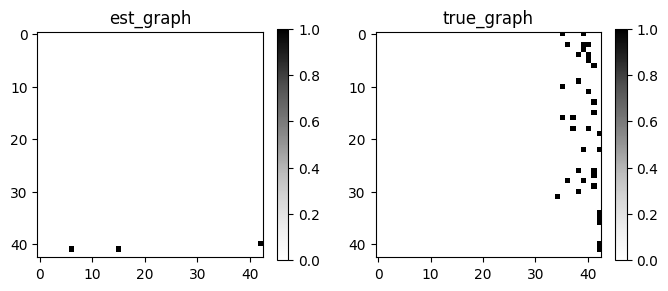

Results added to 'testing_results.csv'.
PC_10000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


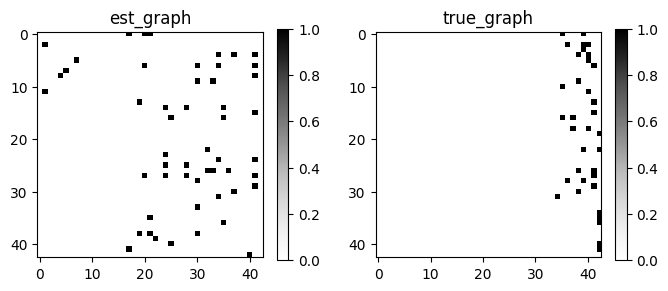

Results added to 'testing_results.csv'.


In [73]:
ground_truth = pd.read_csv('data/causalAssembly/custom_line2/custom_line2_ground_truth.csv').to_numpy()

sample_sizes_cA_custom_line2 = sample_sizes_cA_custom_line2[4:5]

# go over sample sizes
for sample_size in sample_sizes_cA_custom_line2:

    data = pd.read_csv(f'data/causalAssembly/custom_line2/custom_line2_data_{sample_size}.csv').to_numpy()

    # go over all algorithms
    for algorithm in algorithms:
        
        # set different params for the different models
        match algorithm:

            case 'NotearsLinear':
                model = Notears()
                start_time = time.time()
                model.learn(data)
                end_time = time.time()             

            case 'DagmaLinear':
                model = DagmaLinear(loss_type='logistic')
                start_time = time.time()
                W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
                end_time = time.time()
                
            case 'GAE':
                model = GAE(epochs=3)
                start_time = time.time()
                model.learn(data)
                end_time = time.time()

            case 'DirectLiNGAM':
                model = DirectLiNGAM()
                start_time = time.time()
                model.learn(data)
                end_time = time.time()

            case 'PC':
                model = PC(variant = 'stable')
                start_time = time.time()
                model.learn(data)
                end_time = time.time()
                               
                
             
        # calculate runtime
        runtime = end_time - start_time
    
        # plot comparison graph
        name = f'{algorithm}_{sample_size}'
        print(name)
        save_name = f'plots/adj_matrix/causalAssembly/custom_line2/{name}.png'

        match algorithm:
            case 'NotearsLinear':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'DagmaLinear':
                met = MetricsDAG(W_est, ground_truth)
                GraphDAG(W_est, ground_truth, save_name = save_name)
            case 'GAE':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'DirectLiNGAM':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'PC':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
        
        # save metrics to csv
        add_results('causalAssembly', 'custom_line2', sample_size, algorithm, runtime, None, met.metrics) 


# IID_Simulation

create data

In [96]:
# create data  
dag = DAG.scale_free(n_nodes=34, n_edges=40)
sample_sizes_IID = [500, 1000, 2000, 5000, 10000]

for sample_size in sample_sizes_IID:   
    IIDSimulation_data = IIDSimulation(W=dag, n=sample_size, method='linear', sem_type='logistic')
    # save data to csv
    data = pd.DataFrame(IIDSimulation_data.X)
    data.to_csv(f'data/IID/IID_simulated_data_{data.shape[0]}.csv', index=False)
    print(f"saved data for sample size {sample_size}")

# save ground truth to csv
ground_truth = pd.DataFrame(IIDSimulation_data.B)
ground_truth.to_csv(f'data/IID/IID_simulated_ground_truth.csv', index=False)

2024-06-25 14:17:26,621 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-25 14:17:26,638 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-25 14:17:26,699 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-25 14:17:26,817 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 500
saved data for sample size 1000
saved data for sample size 2000


2024-06-25 14:17:27,027 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 5000
saved data for sample size 10000


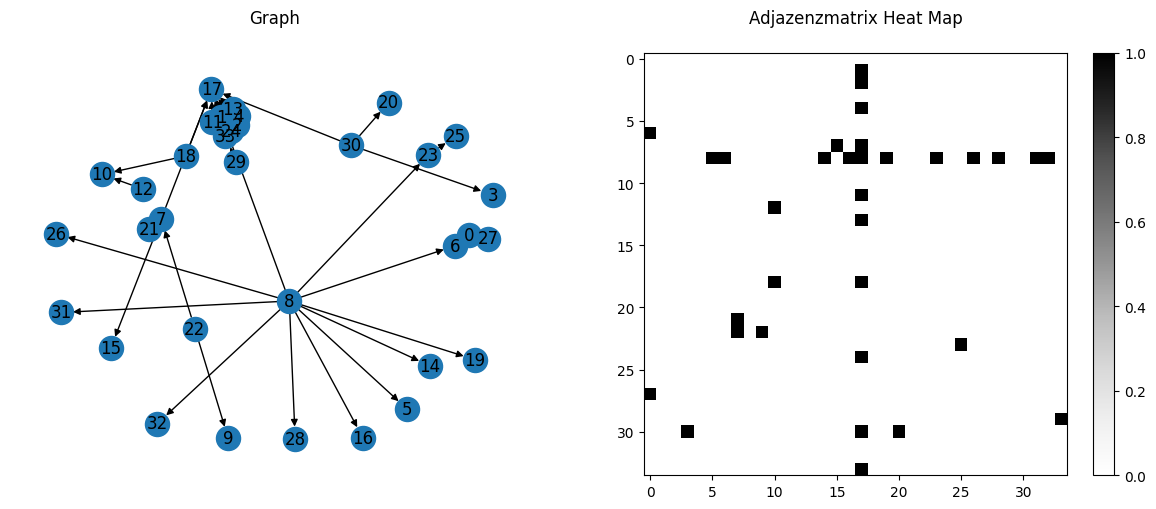

In [63]:
# read data
ground_truth = pd.read_csv('data/IID/IID_simulated_ground_truth.csv').to_numpy()
save_name = 'plots/graphs/IID/all/IID_simulated_ground_truth.png'
plot_graph_adjacency_matrix(ground_truth, save_name)

## TESTS

In [ ]:
from castle.algorithms import Notears
from dagma.linear import DagmaLinear
from castle.algorithms import GAE
from castle.algorithms import DirectLiNGAM
from castle.algorithms import PC


In [125]:
algorithms = [
    # 'NotearsLinear'
    # ,'DagmaLinear'
    # ,'GAE'
    'DirectLiNGAM'
    , 'PC'
    ]

In [114]:
sample_sizes_IID[4:5]

[10000]

DirectLiNGAM_500


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


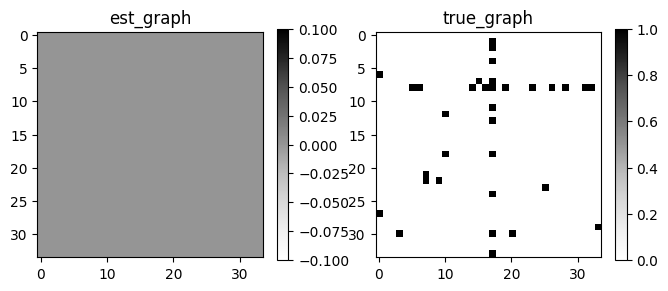

Results added to 'testing_results.csv'.
PC_500


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


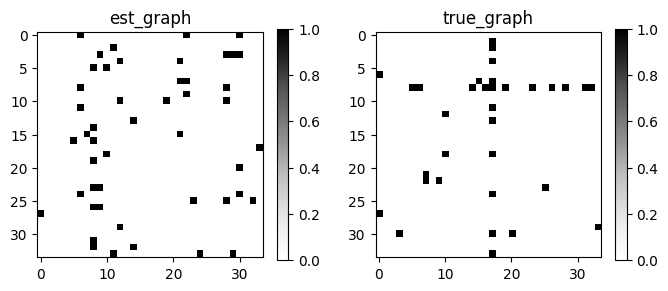

Results added to 'testing_results.csv'.
DirectLiNGAM_1000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

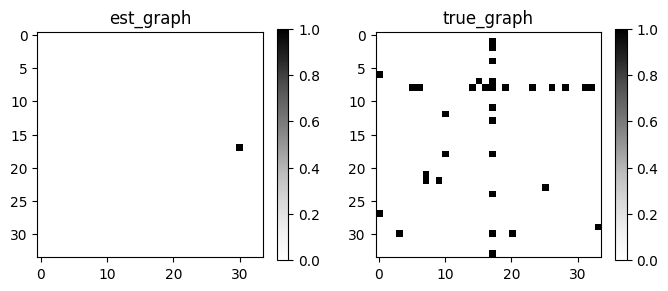

Results added to 'testing_results.csv'.
PC_1000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


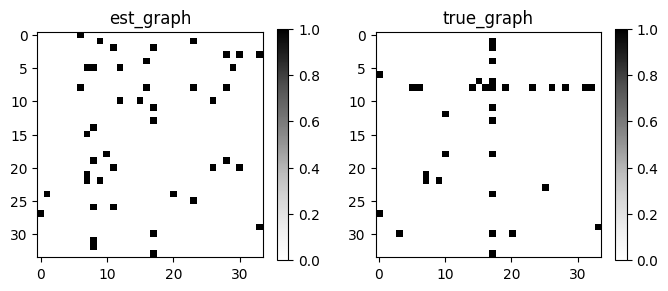

Results added to 'testing_results.csv'.
DirectLiNGAM_2000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

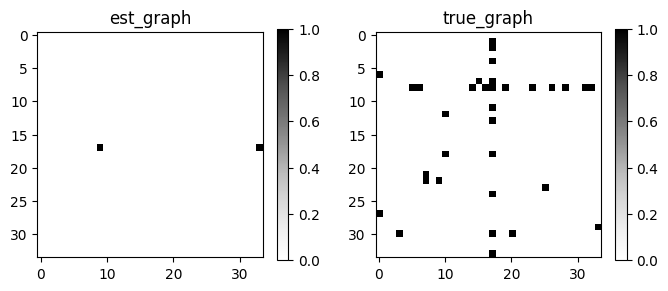

Results added to 'testing_results.csv'.
PC_2000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


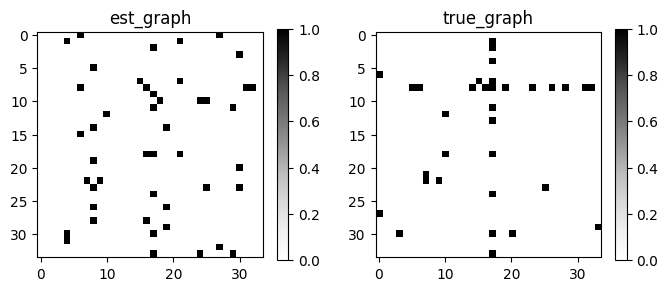

Results added to 'testing_results.csv'.
DirectLiNGAM_5000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


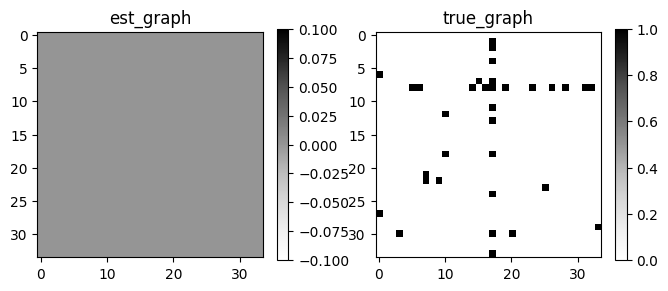

Results added to 'testing_results.csv'.
PC_5000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


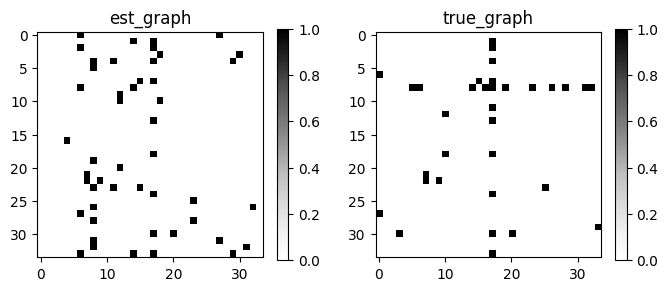

Results added to 'testing_results.csv'.
DirectLiNGAM_10000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


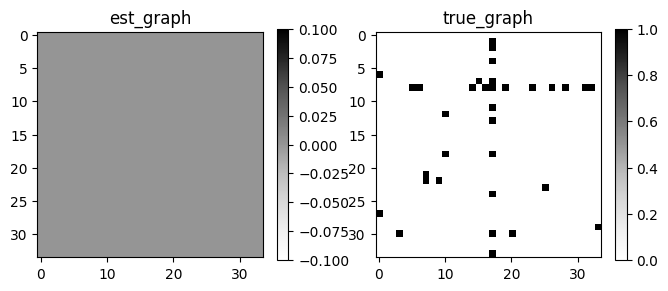

Results added to 'testing_results.csv'.
PC_10000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


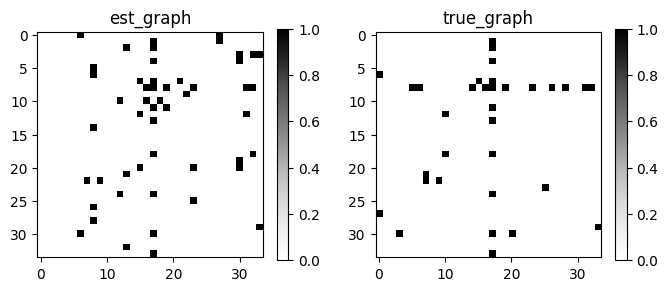

Results added to 'testing_results.csv'.


In [126]:
ground_truth = pd.read_csv('data/IID/IID_simulated_ground_truth.csv').to_numpy()

# go over sample sizes
for sample_size in sample_sizes_IID:

    data = pd.read_csv(f'data/IID/IID_simulated_data_{sample_size}.csv').to_numpy()

    # go over all algorithms
    for algorithm in algorithms:
        
        # set different params for the different models
        match algorithm:

            case 'NotearsLinear':
                model = Notears()
                start_time = time.time()
                model.learn(data)
                end_time = time.time()             

            case 'DagmaLinear':
                model = DagmaLinear(loss_type='logistic')
                start_time = time.time()
                W_est = (model.fit(data, max_iter=1e6) > 0.5).astype("int32")
                end_time = time.time()
                
            case 'GAE':
                model = GAE(epochs=3)
                start_time = time.time()
                model.learn(data)
                end_time = time.time()

            case 'DirectLiNGAM':
                model = DirectLiNGAM()
                start_time = time.time()
                model.learn(data)
                end_time = time.time()

            case 'PC':
                model = PC(variant = 'stable')
                start_time = time.time()
                model.learn(data)
                end_time = time.time()
                               
                
             
        # calculate runtime
        runtime = end_time - start_time
    
        # plot comparison graph
        name = f'{algorithm}_{sample_size}'
        print(name)
        save_name = f'plots/adj_matrix/IID/{name}.png'

        match algorithm:
            case 'NotearsLinear':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'DagmaLinear':
                met = MetricsDAG(W_est, ground_truth)
                GraphDAG(W_est, ground_truth, save_name = save_name)
            case 'GAE':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'DirectLiNGAM':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
            case 'PC':
                met = MetricsDAG(model.causal_matrix, ground_truth)
                GraphDAG(model.causal_matrix, ground_truth, save_name = save_name)
        
        # save metrics to csv
        add_results('IID', 'Simulated', sample_size, algorithm, runtime, None, met.metrics) 


# IID2_Simulation

create data

2024-06-27 11:06:02,757 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-27 11:06:02,784 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-27 11:06:02,855 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 500
saved data for sample size 1000


2024-06-27 11:06:02,993 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 2000
saved data for sample size 5000


2024-06-27 11:06:03,223 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 10000


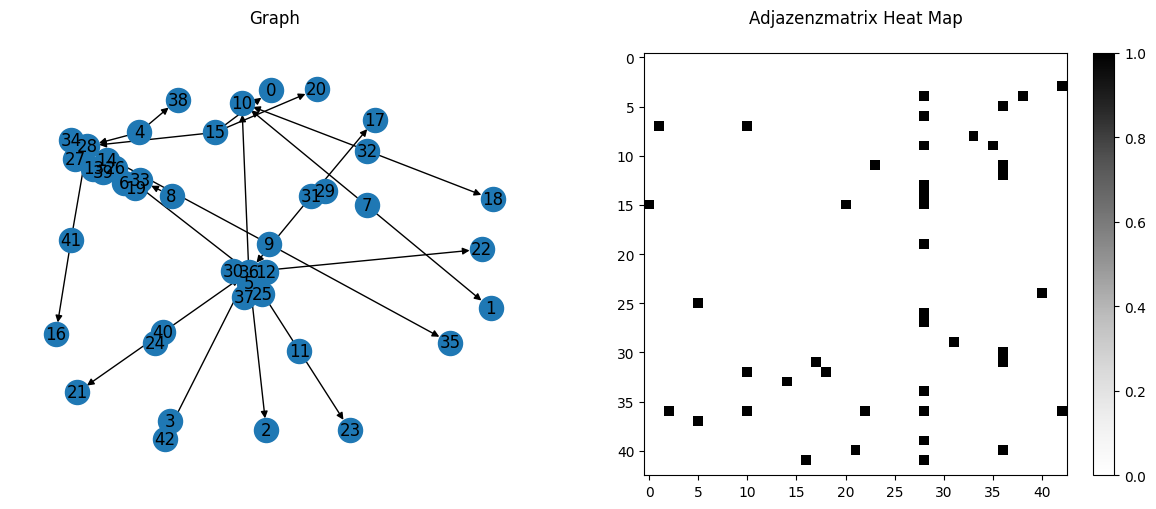

In [152]:
IID_version = 'IID2'

# create data  
dag = DAG.scale_free(n_nodes=43, n_edges=50)
sample_sizes_IID = [500, 1000, 2000, 5000, 10000]

for sample_size in sample_sizes_IID:   
    IIDSimulation_data = IIDSimulation(W=dag, n=sample_size, method='linear', sem_type='logistic')
    # save data to csv
    data = pd.DataFrame(IIDSimulation_data.X)
    data.to_csv(f'data/IID/{IID_version}/{IID_version}_simulated_data_{data.shape[0]}.csv', index=False)
    print(f"saved data for sample size {sample_size}")

# save ground truth to csv
ground_truth = pd.DataFrame(IIDSimulation_data.B)
ground_truth.to_csv(f'data/IID/{IID_version}/{IID_version}_simulated_ground_truth.csv', index=False)


ground_truth = pd.read_csv(f'data/IID/{IID_version}/{IID_version}_simulated_ground_truth.csv').to_numpy()
save_name = f'plots/graphs/IID/{IID_version}/{IID_version}_simulated_ground_truth.png'
plot_graph_adjacency_matrix(ground_truth, save_name)

## TESTS

# IID3

2024-06-27 11:09:01,927 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-27 11:09:01,948 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset
2024-06-27 11:09:02,023 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 500
saved data for sample size 1000


2024-06-27 11:09:02,165 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 2000


2024-06-27 11:09:02,389 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/datasets/simulator.py[line:270] - INFO: Finished synthetic dataset


saved data for sample size 5000
saved data for sample size 10000


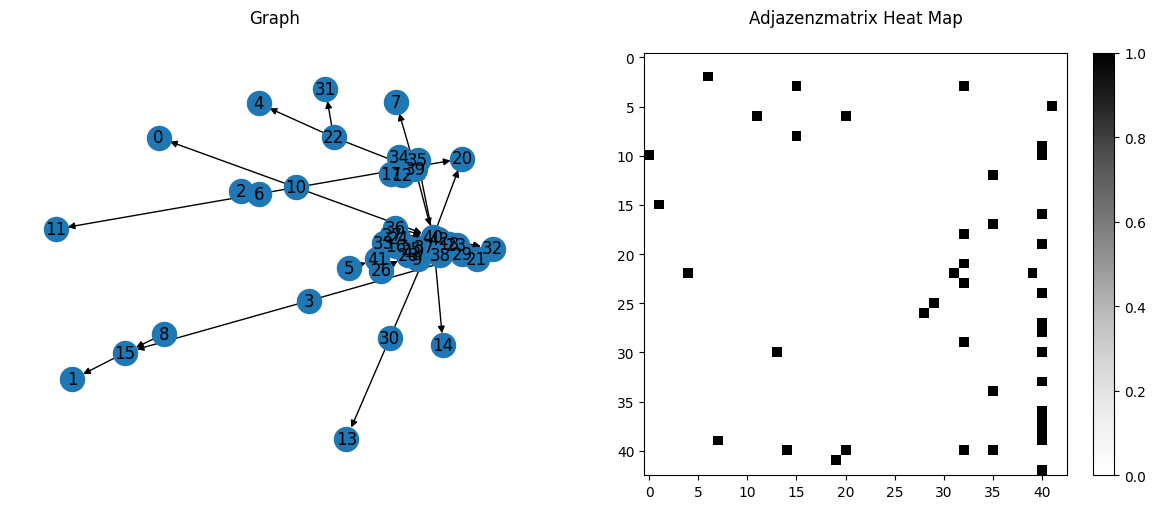

In [162]:
IID_version = 'IID3'


In [ ]:

# create data  
dag = DAG.scale_free(n_nodes=43, n_edges=50)
sample_sizes_IID = [500, 1000, 2000, 5000, 10000]

for sample_size in sample_sizes_IID:   
    IIDSimulation_data = IIDSimulation(W=dag, n=sample_size, method='linear', sem_type='logistic')
    # save data to csv
    data = pd.DataFrame(IIDSimulation_data.X)
    data.to_csv(f'data/IID/{IID_version}/{IID_version}_simulated_data_{data.shape[0]}.csv', index=False)
    print(f"saved data for sample size {sample_size}")

# save ground truth to csv
ground_truth = pd.DataFrame(IIDSimulation_data.B)
ground_truth.to_csv(f'data/IID/{IID_version}/{IID_version}_simulated_ground_truth.csv', index=False)



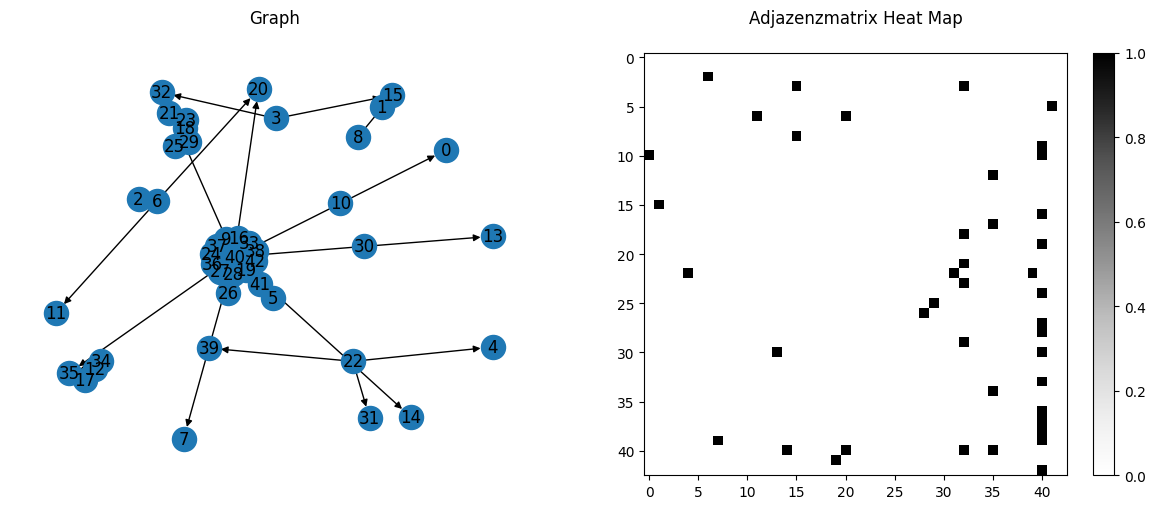

In [174]:

ground_truth = pd.read_csv(f'data/IID/{IID_version}/{IID_version}_simulated_ground_truth.csv').to_numpy()
save_name = f'plots/graphs/IID/{IID_version}/{IID_version}_simulated_ground_truth.png'
plot_graph_adjacency_matrix(ground_truth, save_name)

## TESTS

In [279]:
algorithms = [
    'NotearsLinear'
    ,'DagmaLinear'
    ,'GAE'
    , 'DirectLiNGAM'
    # , 'PC'
    ]

sample_sizes_IID3 = [2000, 5000, 10000]

2024-06-27 14:41:53,489 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=2000, d=43, iter_=100, h_=1e-08, rho_=1e+16
2024-06-27 14:41:53,533 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=0.000e+00, loss=4.866, rho=1.0e+00
2024-06-27 14:41:53,534 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:222] - INFO: FINISHED


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


NotearsLinear_2000


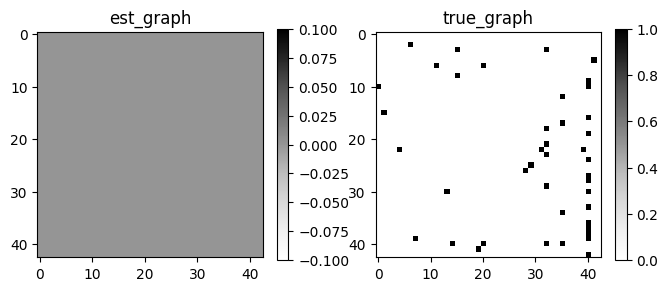

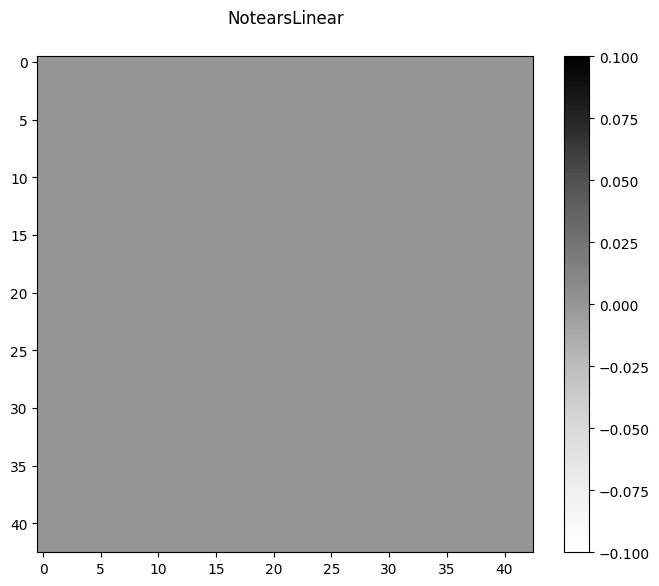

Results added to 'testing_results.csv'.


100%|██████████| 1120000/1120000.0 [01:25<00:00, 13122.57it/s]
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


DagmaLinear_2000


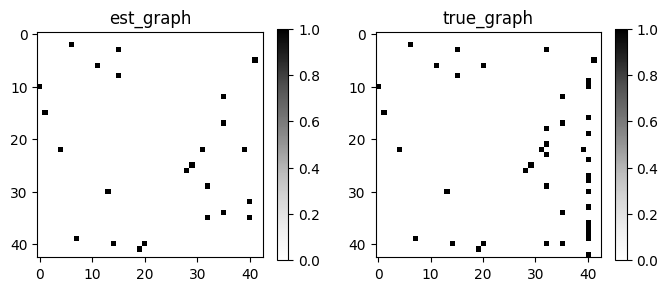

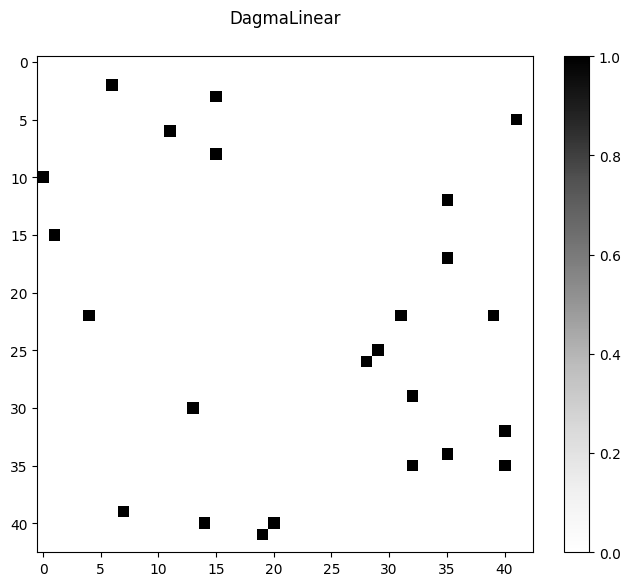

2024-06-27 14:43:20,681 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-27 14:43:20,683 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-27 14:43:20,692 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 35.74383933986826


Results added to 'testing_results.csv'.


2024-06-27 14:43:22,088 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 4.897498461652069
2024-06-27 14:43:23,473 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 400: 4.870752581609422
2024-06-27 14:43:24,856 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 600: 4.865743241284778
2024-06-27 14:43:26,237 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 800: 4.861280763378195
2024-06-27 14:43:27,627 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/

GAE_2000


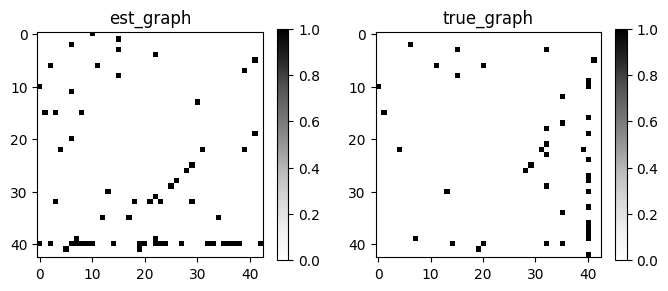

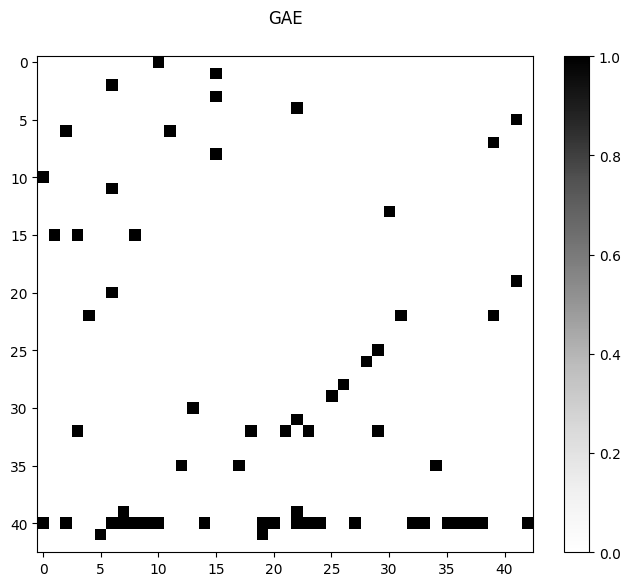

Results added to 'testing_results.csv'.
DirectLiNGAM_2000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


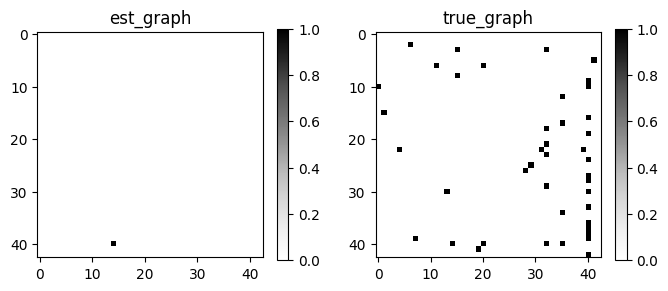

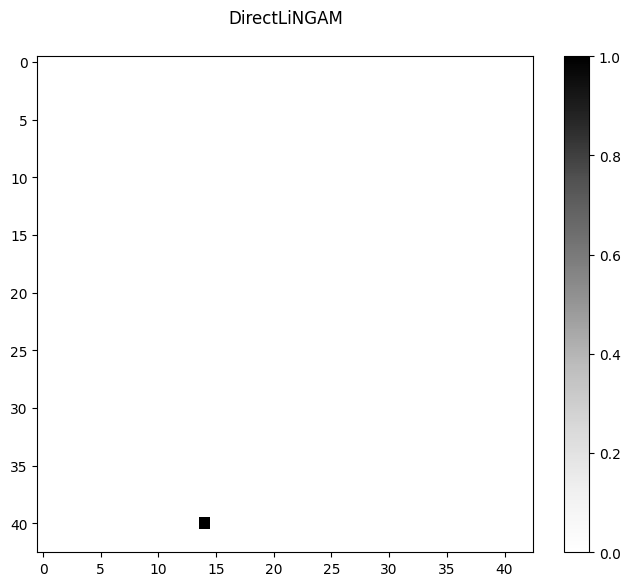

2024-06-27 14:45:34,654 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=5000, d=43, iter_=100, h_=1e-08, rho_=1e+16
2024-06-27 14:45:34,700 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=0.000e+00, loss=4.864, rho=1.0e+00
2024-06-27 14:45:34,702 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:222] - INFO: FINISHED


Results added to 'testing_results.csv'.
NotearsLinear_5000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


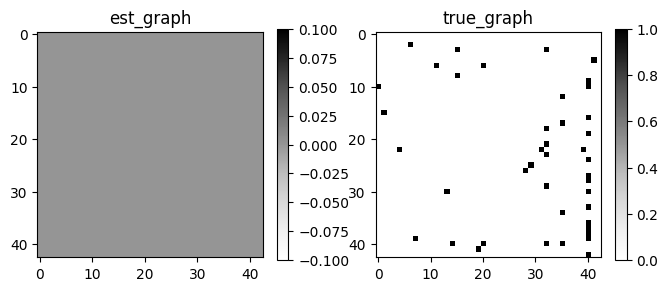

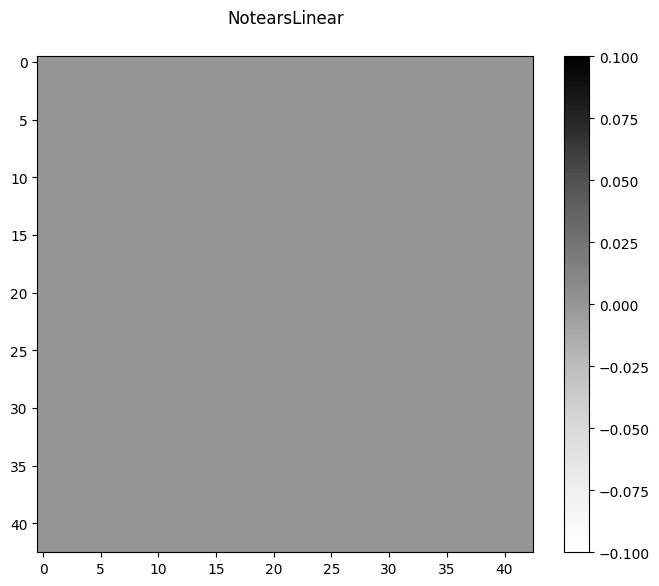

Results added to 'testing_results.csv'.


100%|██████████| 1120000/1120000.0 [02:57<00:00, 6300.00it/s] 
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()


DagmaLinear_5000


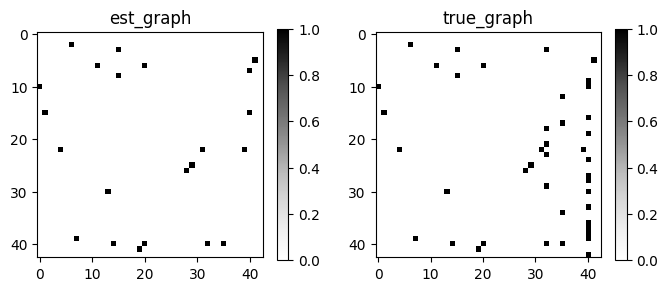

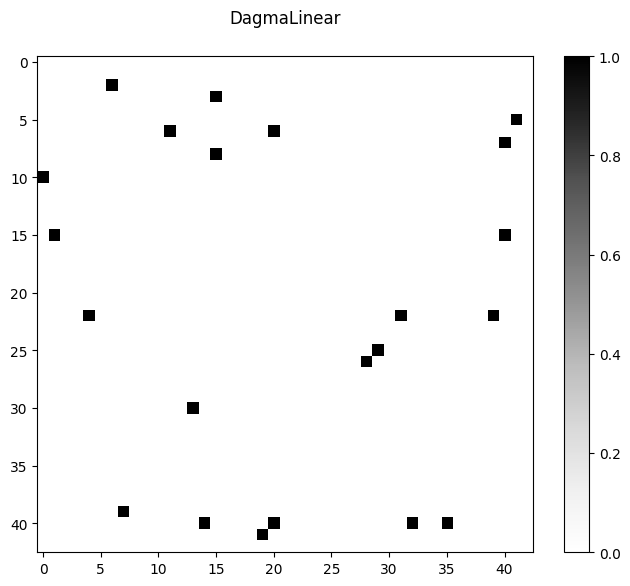

2024-06-27 14:48:34,278 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/gae.py[line:144] - INFO: GPU is available.
2024-06-27 14:48:34,280 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:58] - INFO: Current epoch: 1==================
2024-06-27 14:48:34,298 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 0: 35.789372262361226


Results added to 'testing_results.csv'.


2024-06-27 14:48:36,908 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 200: 4.897679714162945
2024-06-27 14:48:39,497 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 400: 4.871394740189567
2024-06-27 14:48:42,091 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 600: 4.866638417830986
2024-06-27 14:48:44,677 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/trainers/al_trainer.py[line:104] - INFO: Current loss in step 800: 4.862666659106192
2024-06-27 14:48:47,259 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/gae/torch/

GAE_5000


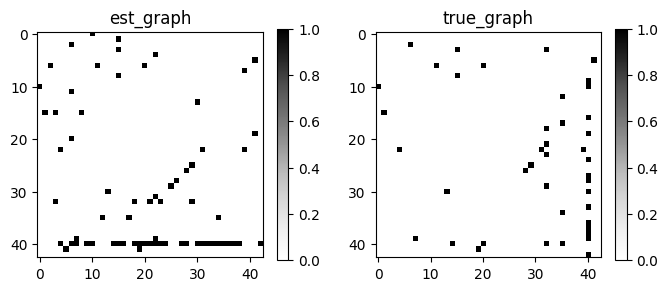

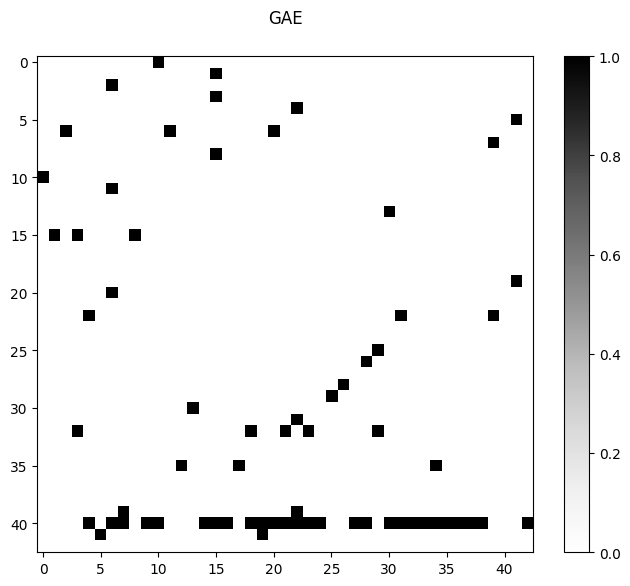

Results added to 'testing_results.csv'.
DirectLiNGAM_5000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:226: RuntimeWarning: invalid value encountered in scalar divide
  F1 = 2*(recall*precision

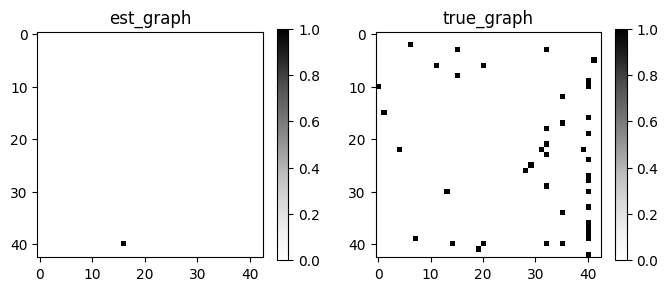

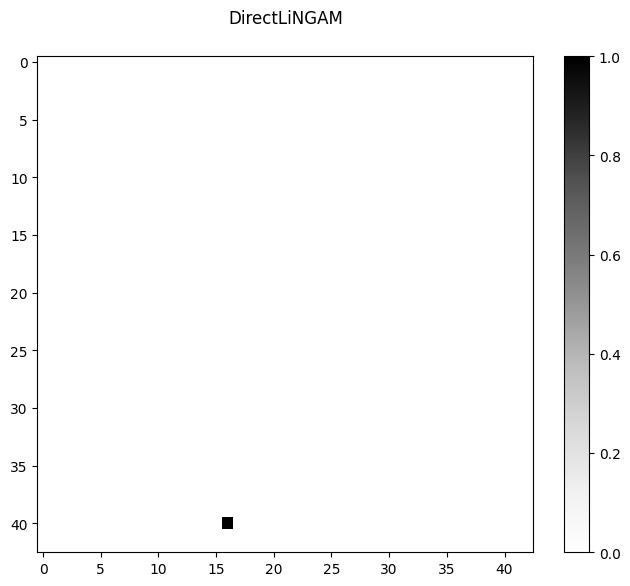

2024-06-27 14:52:34,450 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:195] - INFO: [start]: n=10000, d=43, iter_=100, h_=1e-08, rho_=1e+16
2024-06-27 14:52:34,512 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:206] - INFO: [iter 0] h=0.000e+00, loss=4.862, rho=1.0e+00
2024-06-27 14:52:34,514 - /home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:222] - INFO: FINISHED


Results added to 'testing_results.csv'.
NotearsLinear_10000


/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:193: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_tp =  (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:195: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_fn_r = (W_p - W_true).applymap(lambda elem:1 if elem==1 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:221: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  TP = (W_p + W_true).applymap(lambda elem:1 if elem==2 else 0).sum(axis=1).sum()
/home/ubuntu/code/causal-learning/.venv/lib/python3.10/site-packages/castle/metrics/evaluation.py:224: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP/TP_FP


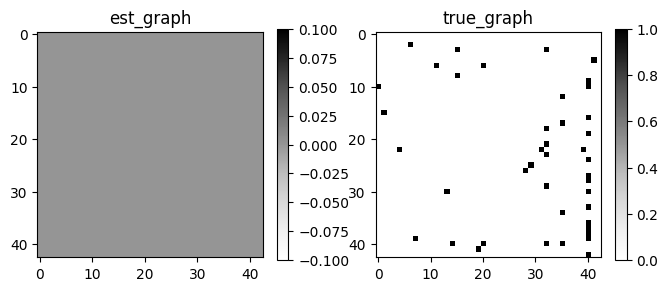

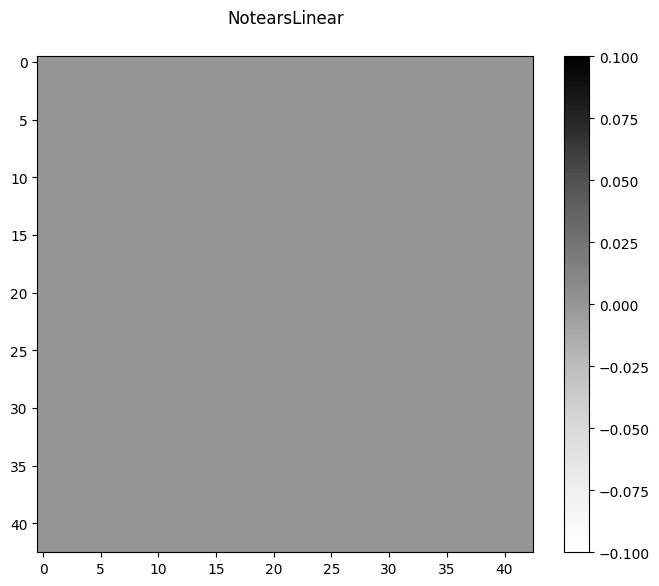

Results added to 'testing_results.csv'.


  0%|          | 4215/1120000.0 [00:56<4:09:01, 74.68it/s]


KeyboardInterrupt: 

In [280]:
run_tests('IID', 'IID3', algorithms, sample_sizes_IID3)

# RESULTS

per dataset - subset - n

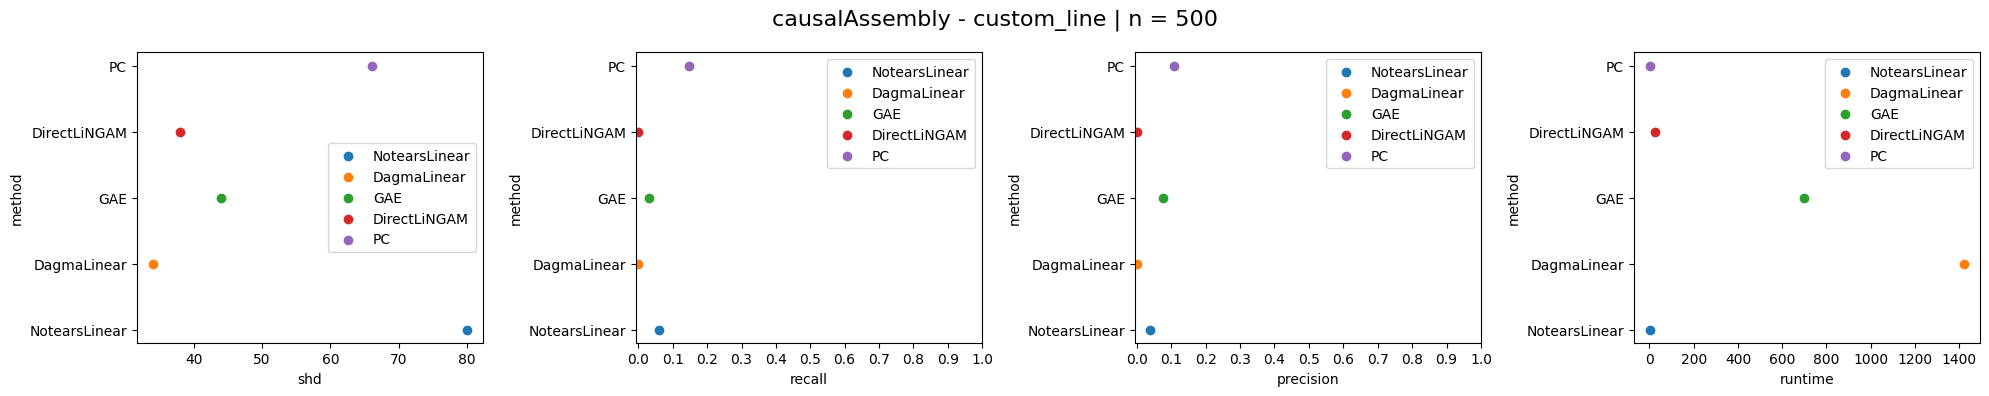

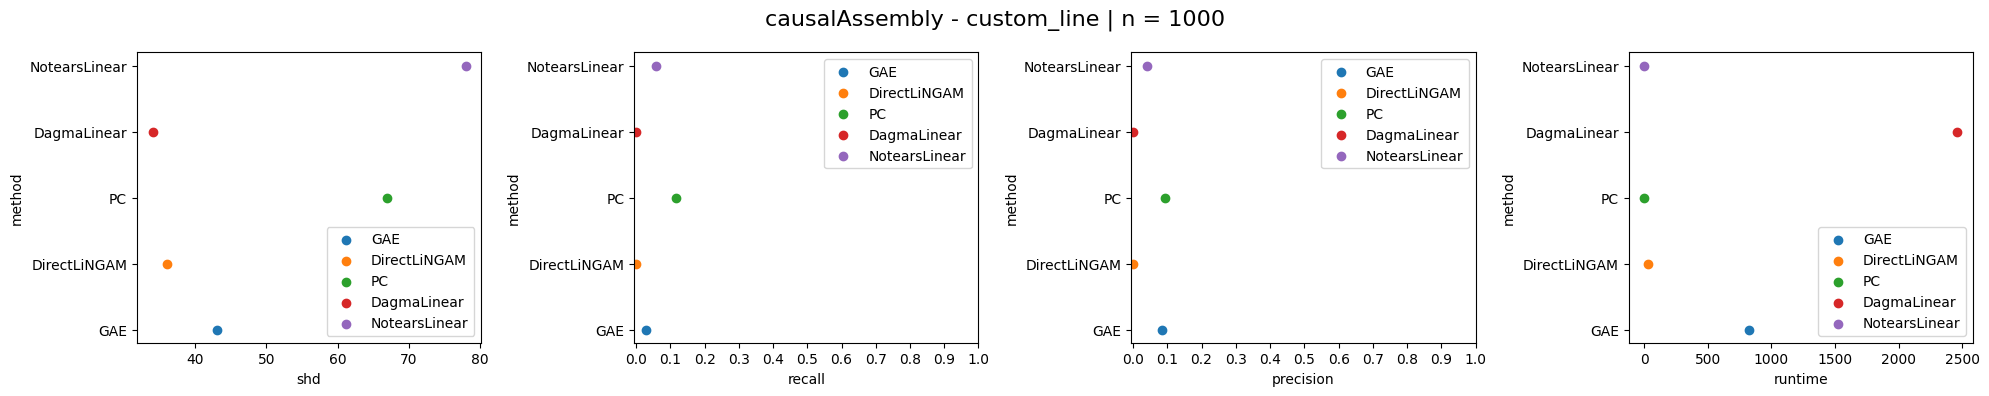

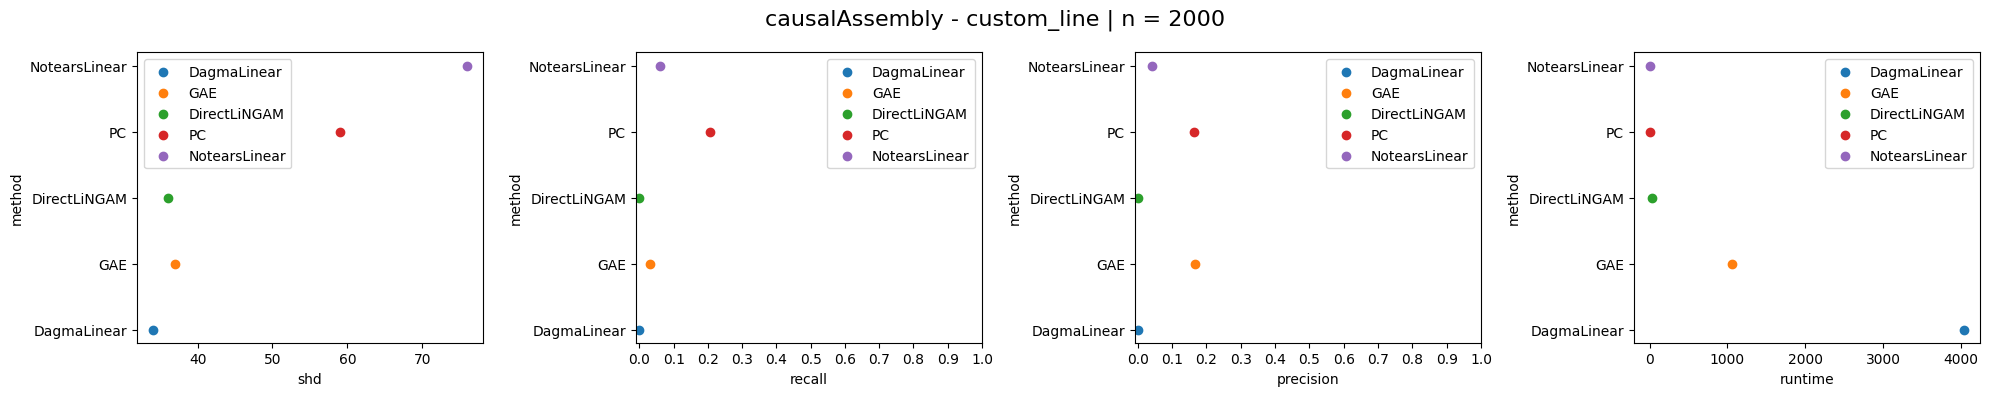

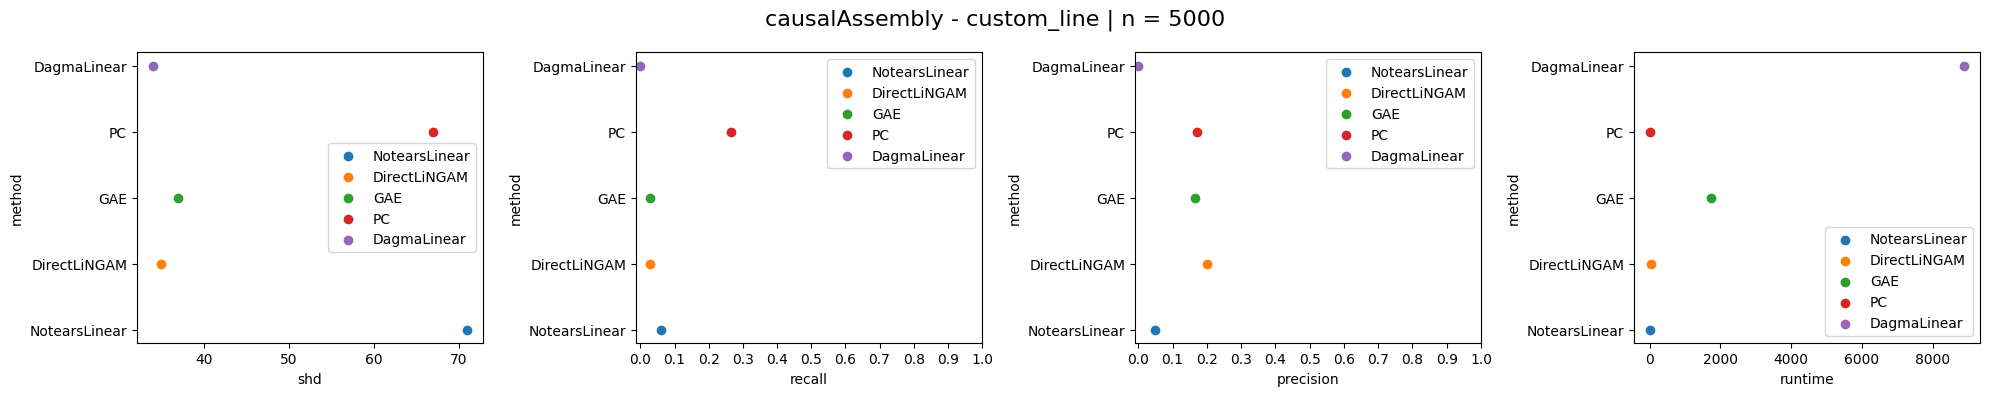

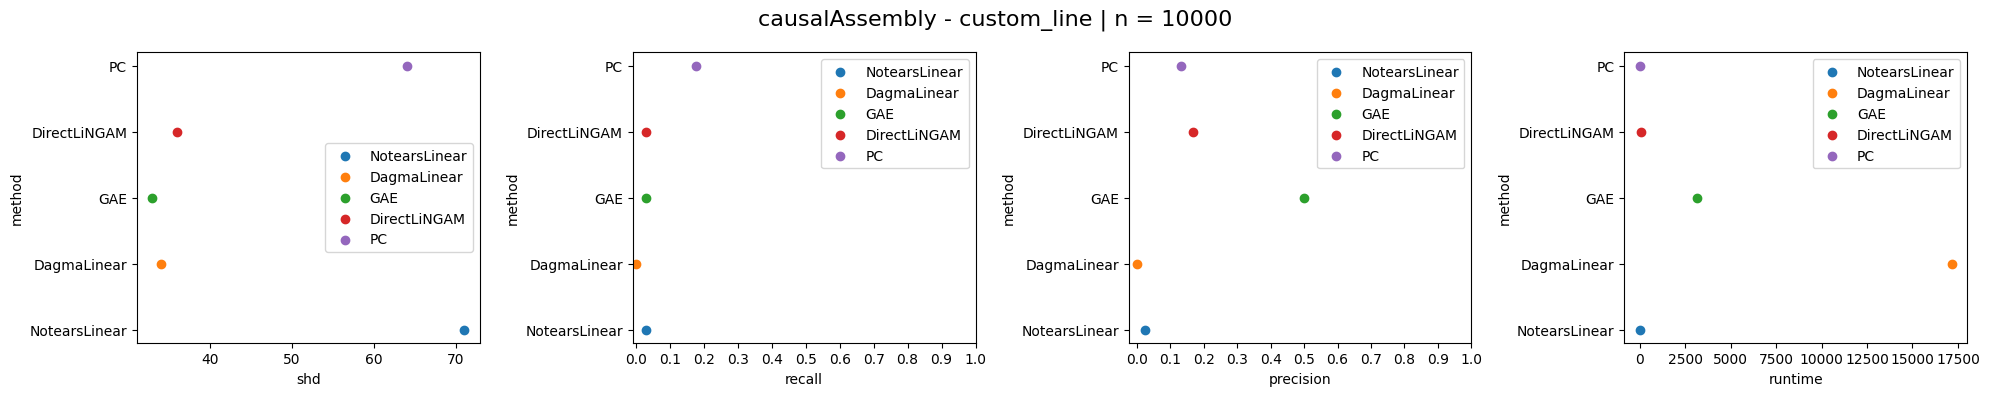

In [112]:
import matplotlib.pyplot as plt
import numpy as np

testing_results = pd.read_csv('testing_results.csv')
testing_results = testing_results.fillna(0)

# narrow down dataset
# testing_results = testing_results[testing_results['dataset'] == 'IID']

testing_results = testing_results[
                                #     (testing_results['dataset'] == 'causalAssembly')
                                #   & (testing_results['subset'] == 'custom_line')
                                  (testing_results['date'] >= '2024-06-25 16:00:00')
                                  ]

# clean up testing data
testing_results.drop_duplicates(subset=['method', 'n'], inplace=True)
testing_results.sort_values(by='n', inplace=True)

# specify metrics
metrics = ['shd', 'recall', 'precision', 'runtime']  

for dataset in testing_results['dataset'].unique():
    dataset_results = testing_results[testing_results['dataset'] == dataset]
    
    for subset in dataset_results['subset'].unique():
        subset_results = dataset_results[dataset_results['subset'] == subset]
        
        for n in subset_results['n'].unique():
            subset_results_n = subset_results[subset_results['n'] == n]
            
            # Create a figure with the desired number of subplots (one for each metric)
            fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

            # Set the overall title
            fig.suptitle(f'{dataset} - {subset} | n = {n}', fontsize=16)
            
            for i, metric in enumerate(metrics):
                ax = axes[i]
                
                for method in subset_results_n['method'].unique():
                    method_results = subset_results_n[subset_results_n['method'] == method]
                    ax.scatter(method_results[metric], method_results['method'], label=method)
                
                # ax.set_title(f'{dataset} - {subset} | n = {n} | {metric}')
                ax.set_xlabel(metric)
                if metric not in ('shd', 'runtime'):
                    ax.set_xticks(np.arange(0, 1.1, 0.1))
                ax.set_ylabel('method')
                ax.legend()
            
            plt.tight_layout()
            plt.show()

per dataset - subset: over all metrics

comparison of adjacency matrices vs ground truth

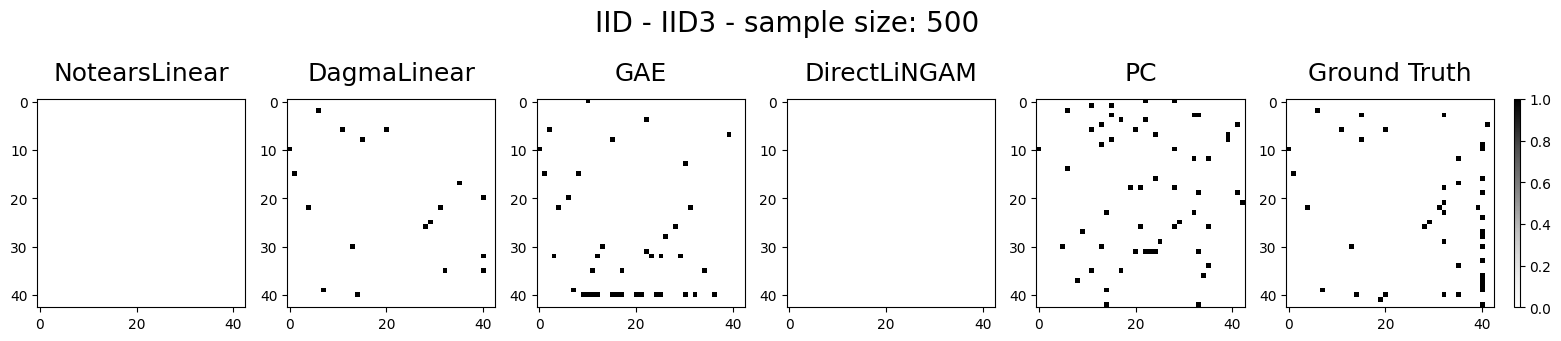

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Specify algorithms
algorithms = ['NotearsLinear', 'DagmaLinear', 'GAE', 'DirectLiNGAM', 'PC']

# Specify sample sizes
sample_sizes = [500]

# Specify dataset
dataset = 'IID'
subset = 'IID3'

for sample_size in sample_sizes:

    # Create figure with as many subplots as algorithms plus one for the ground truth
    fig, axes = plt.subplots(1, len(algorithms) + 1, figsize=(20, 4), gridspec_kw={'width_ratios': [1] * len(algorithms) + [1]})

    # Set the overall title
    fig.suptitle(f'{dataset} - {subset} - sample size: {sample_size}', fontsize=20)

    # Create a subplot for each algorithm
    for i, algorithm in enumerate(algorithms):
        ax = axes[i]
        
        # Get the data
        adj_matrix = pd.read_csv(f'plots/adj_matrix_csv/{dataset}/{subset}/{algorithm}_{sample_size}.csv').to_numpy()

        ax.set_title(algorithm, y= 1.05, fontsize = 18)
        map1 = ax.imshow(adj_matrix, cmap='Greys', interpolation='none')

    # Also plot the ground truth
    ax_ground_truth = axes[-1]
    adj_matrix_ground_truth = pd.read_csv(f'data/{dataset}/{subset}/{subset}_ground_truth.csv').to_numpy()
    
    ax_ground_truth.set_title('Ground Truth', y=1.05, fontsize = 18)
    map2 = ax_ground_truth.imshow(adj_matrix_ground_truth, cmap='Greys', interpolation='none')

    # Add colorbar
    cbar = fig.colorbar(map2, ax=axes, location='right', aspect=40, fraction=0.02, pad=0.04)
    cbar.ax.set_position([ax_ground_truth.get_position().x1 + 0.01, ax_ground_truth.get_position().y0, 0.02, ax_ground_truth.get_position().height])
    
plt.show()


comparison of runtimes

                    date         dataset       subset      n  \
2    2024-06-24 12:54:17  causalAssembly  custom_line    500   
3    2024-06-24 12:54:34  causalAssembly  custom_line   2000   
4    2024-06-24 12:54:42  causalAssembly  custom_line   5000   
5    2024-06-24 12:56:28  causalAssembly  custom_line    500   
6    2024-06-24 13:06:50  causalAssembly  custom_line   2000   
113  2024-06-25 11:25:28  causalAssembly  custom_line    500   
114  2024-06-25 11:26:50  causalAssembly  custom_line   2000   
115  2024-06-25 11:28:26  causalAssembly  custom_line   5000   
116  2024-06-25 11:39:08  causalAssembly  custom_line    500   
117  2024-06-25 11:40:36  causalAssembly  custom_line   2000   
118  2024-06-25 11:41:28  causalAssembly  custom_line   5000   
119  2024-06-25 11:44:28  causalAssembly  custom_line    500   
120  2024-06-25 11:44:39  causalAssembly  custom_line   2000   
121  2024-06-25 11:44:55  causalAssembly  custom_line   5000   
125  2024-06-25 13:59:17  causalAssembly

/tmp/ipykernel_56953/4122462661.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_56953/4122462661.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


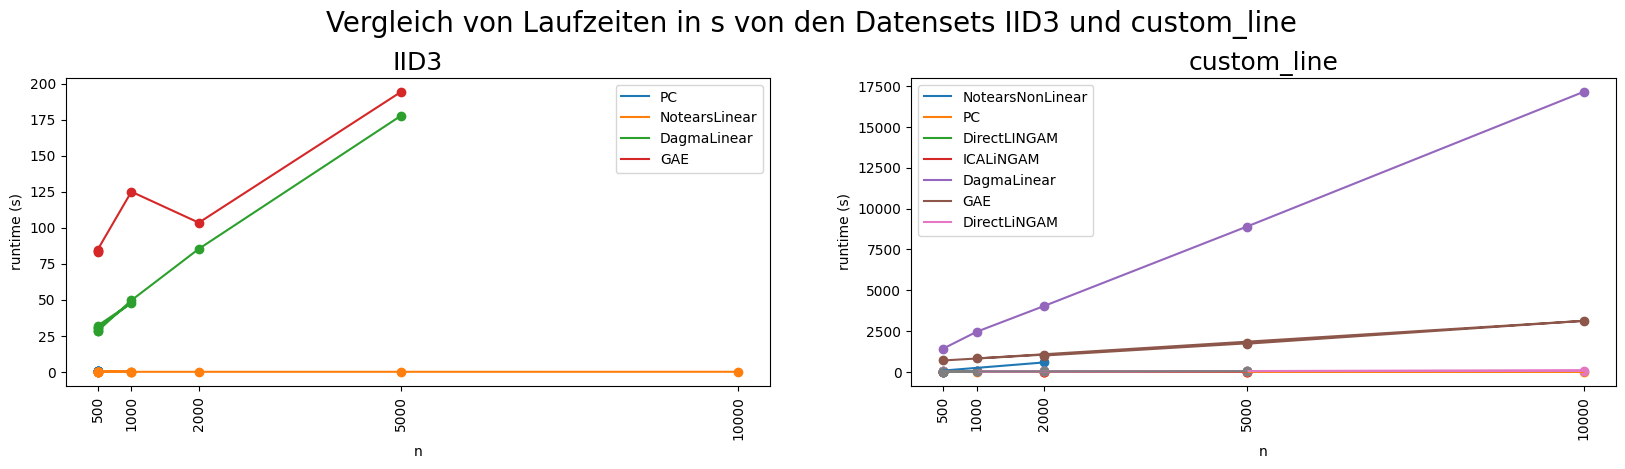

In [18]:
import matplotlib.pyplot as plt

algorithms = ['NotearsLinear', 'DagmaLinear', 'GAE', 'DirectLiNGAM', 'PC']

sample_sizes = [500, 1000, 2000, 5000, 10000]

datasets = ['IID', 'causalAssembly']
subsets = ['IID3', 'custom_line']

# load data
testing_results = pd.read_csv('testing_results.csv')
testing_results = testing_results.fillna(0)

# narrow down dataset
testing_results = testing_results[
                                    (testing_results['dataset'].isin(datasets))
                                  & (testing_results['subset'].isin(subsets))
                                #   (testing_results['date'] >= '2024-06-25 16:00:00')
                                  ]

fig, axs = plt.subplots(1, len(subsets), figsize = (20,4))
fig.suptitle(f'Vergleich von Laufzeiten in s von den Datensets {subsets[0]} und {subsets[1]} ', fontsize=20, y= 1.05)

for dataset in testing_results['dataset'].unique():
    for subset in testing_results[testing_results['dataset'] == dataset]['subset'].unique():
        subset_results = testing_results[(testing_results['dataset'] == dataset) & (testing_results['subset'] == subset)]

        print (subset_results)

        # plot the runtime over n

        # Create a dictionary to store the data for each method
        method_data = {}
        
        for method in subset_results['method'].unique():
          method_results = subset_results[subset_results['method'] == method]
          x = method_results['n']
          y = method_results['runtime']
          
          # Store the data for each method
          method_data[method] = (x, y)
        
        # Plot the data for each method
        for method, (x, y) in method_data.items():
          ax.plot(x, y, label=method)
          ax.scatter(x, y)

          ax = axs[subsets.index(subset)]
          ax.set_title(subset, fontsize=18)
          ax.set_xlabel('n')
          ax.set_ylabel('runtime (s)')
          ax.set_xticks(sample_sizes)
          ax.tick_params(axis='x', labelrotation=90)
          ax.legend()

